# MA Crossover Strategy Code vvv

This script functions as an analytical tool for use in determining the historical profitabilities for a given pair of signal and control moving average (MA) lengths for three types of moving average (simple, weighted, exponential). It then visualizes the strategy and demonstrates the cumulative profit curves for each MA style after commission fees have been accounted for. Some additional exploratory analysis is included in the script. This still is a work in progress with much yet left to do and I have already advanced it past the point that was necessary to complete my MSBA capstone. As such, some of the output of this script may not yet be reflected in the written report on this script's findings.

#### Import all modules, packages, tools that might be used in the code.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import itertools
import scipy.stats as stats
import os
import re
import datetime 
from zipfile import ZipFile
import pandas_gbq
import janitor
import shutil
import glob
from google.cloud import bigquery
from google.oauth2 import service_account
import pandoc
from tabulate import tabulate
import warnings

#### These functions will change the number of rows and columns so you can view all of the data in the table. They also alter some data frame display formatting and prevent warnings from printing to output.

In [2]:
# Disable warnings
warnings.filterwarnings("ignore")

In [3]:
# Formats all numerical output to be rounded to three decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# # Allows us to see more rows in the head and tail of data frame output
# pd.set_option('display.max_rows', 30)
# pd.set_option('display.min_rows', 30)

In [5]:
# Output always includes all columns in the data frame
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', 1000)

* Read in ES data to ES and change the column names to make sense. 
* Drop NA's to avoid issues, convert date data type, 
* sort date appropriately, add day number, set index to date.

In [6]:
# Reads in the data to ES
ES = pd.read_csv('ES_Granular/ES_continuous_adjusted_5min.txt', 
                 names = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
ES.dropna(inplace=True)
ES

,Date,Open,High,Low,Close,Volume
0,2005-09-06 16:30:00,1146.250,1146.750,1146.250,1146.500,652
1,2005-09-06 16:35:00,1146.250,1146.500,1146.000,1146.250,571
2,2005-09-06 16:40:00,1146.250,1146.250,1146.000,1146.000,136
3,2005-09-06 16:45:00,1146.000,1146.500,1146.000,1146.250,253
4,2005-09-06 16:50:00,1146.250,1146.500,1146.250,1146.500,33
...,...,...,...,...,...,...
1220689,2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,770
1220690,2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,655
1220691,2023-01-13 16:45:00,4019.000,4019.750,4019.000,4019.500,1009
1220692,2023-01-13 16:50:00,4019.500,4020.000,4019.500,4020.000,675


In [7]:
ES['Date']=pd.to_datetime(ES.Date) # Converts Date columns to datetime format
ES = ES.sort_values(['Date'], ascending = True) # Sorts by Date column so earliest is first
ES = ES.set_index('Date')

time_unit = np.arange(1, len(ES) + 1) # Creates time_unit column
ES['Time_Unit'] = time_unit # Adds time_unit column to dataframe

ES

,Open,High,Low,Close,Volume,Time_Unit
Date,,,,,,
2005-09-06 16:30:00,1146.250,1146.750,1146.250,1146.500,652,1
2005-09-06 16:35:00,1146.250,1146.500,1146.000,1146.250,571,2
2005-09-06 16:40:00,1146.250,1146.250,1146.000,1146.000,136,3
2005-09-06 16:45:00,1146.000,1146.500,1146.000,1146.250,253,4
2005-09-06 16:50:00,1146.250,1146.500,1146.250,1146.500,33,5
...,...,...,...,...,...,...
2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,770,1220690
2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,655,1220691
2023-01-13 16:45:00,4019.000,4019.750,4019.000,4019.500,1009,1220692


In [8]:
# Adjust the volume ma here
vma = 10

ES.drop(columns=['Mean', 'vma', 'vol-vma','span','body'], inplace=True, errors='ignore')

ES['Mean']=(ES['High']+ ES['Low']+ES['Open']+ES['Close'])/4 # Creates average of our price candle components
ES['span'] = ES['High'] - ES['Low'] # Creates a measure of candle size
ES['body'] = abs(ES['Close'] - ES['Open']) # Creates a measure of body size and direction
ES['vma']=ES['Volume'].rolling(vma).mean() # Creates volume moving average using vma as input
ES['vol-vma'] = ES['Volume'] - ES['vma'] # Creates a component of relative volume

ES[5:13]

,Open,High,Low,Close,Volume,Time_Unit,Mean,span,body,vma,vol-vma
Date,,,,,,,,,,,
2005-09-06 16:55:00,1146.250,1146.500,1146.250,1146.500,66,6,1146.375,0.250,0.250,NaN,NaN
2005-09-06 17:00:00,1146.250,1146.500,1146.250,1146.500,60,7,1146.375,0.250,0.250,NaN,NaN
2005-09-06 17:05:00,1146.500,1146.750,1146.500,1146.750,310,8,1146.625,0.250,0.250,NaN,NaN
2005-09-06 17:10:00,1146.500,1146.500,1146.500,1146.500,56,9,1146.500,0.000,0.000,NaN,NaN
2005-09-06 17:15:00,1146.500,1146.500,1146.500,1146.500,114,10,1146.500,0.000,0.000,225.100,-111.100
2005-09-06 17:20:00,1146.500,1146.750,1146.500,1146.500,136,11,1146.562,0.250,0.000,173.500,-37.500
2005-09-06 17:25:00,1146.500,1146.750,1146.500,1146.500,68,12,1146.562,0.250,0.000,123.200,-55.200
2005-09-06 18:00:00,1146.500,1146.500,1146.250,1146.250,107,13,1146.375,0.250,0.250,120.300,-13.300


In [9]:
# This whole chunk is calculating slope of price action
slope_period = 3

ES['day_shift'] = ES['Time_Unit'].shift(slope_period)
ES['mean_shift'] = ES['Mean'].shift(slope_period)
ES['mean_slope'] = (ES['Mean'] - ES['Mean'].shift(slope_period))/(ES['Time_Unit'] - ES['Time_Unit'].shift(slope_period))

ES['open_shift'] = ES['Open'].shift(slope_period)
ES['open_slope'] = (ES['Open'] - ES['Open'].shift(slope_period))/(ES['Time_Unit'] - ES['Time_Unit'].shift(slope_period))

In [10]:
col = ES.pop('Mean')
ES.insert(ES.columns.get_loc('Volume'), 'Mean', col)

In [11]:
ES

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope
Date,,,,,,,,,,,,,,,,
2005-09-06 16:30:00,1146.250,1146.750,1146.250,1146.500,1146.438,652,1,0.500,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-06 16:35:00,1146.250,1146.500,1146.000,1146.250,1146.250,571,2,0.500,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-06 16:40:00,1146.250,1146.250,1146.000,1146.000,1146.125,136,3,0.250,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-06 16:45:00,1146.000,1146.500,1146.000,1146.250,1146.188,253,4,0.500,0.250,NaN,NaN,1.000,1146.438,-0.083,1146.250,-0.083
2005-09-06 16:50:00,1146.250,1146.500,1146.250,1146.500,1146.375,33,5,0.250,0.250,NaN,NaN,2.000,1146.250,0.042,1146.250,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,4018.875,770,1220690,1.000,0.500,14402.900,-13632.900,1220687.000,4015.938,0.979,4015.250,1.083
2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,4019.125,655,1220691,0.500,0.000,12004.300,-11349.300,1220688.000,4017.438,0.562,4016.500,0.917
2023-01-13 16:45:00,4019.000,4019.750,4019.000,4019.500,4019.312,1009,1220692,0.750,0.500,5562.000,-4553.000,1220689.000,4018.438,0.292,4018.000,0.333


In [12]:
# Just figuring out how much time the data covers
from datetime import datetime

delta = ES.index[-1] - ES.index[0]

years = delta.days // 365
months = (delta.days % 365) // 30
days = (delta.days % 365) % 30

print(f"Years: {years}, Months: {months}, Days: {days}")

Years: 17, Months: 4, Days: 13


# Simple Moving Average

* Modify signal and control period lengths for the entire script here.

In [13]:
# The signal variable is used for calculations of fast (signal) MA's
# The control variable is used for calculations of slow (control) MA's
# 'prix_met' stands for price metric on which the MA calculations are based
# - can be set to 'Open', 'High', 'Low', or 'Close'

# # Input functionality V V V
# signal = int(input("Enter the value for the signal period length: "))
# control = int(input("Enter the value for the control period length: "))
# prix_met = input("Enter the candle price metric to be used for your MAs: ")

signal = 1
control = 5
prix_met = 'Open'

In [14]:
# Dropping SMA signal and control columns if they exist
ES.drop(columns=['sma_s', 'sma_c'], inplace=True, errors='ignore')

#  Recalculating them
ES['sma_s'] = ES[prix_met].rolling(signal).mean()
ES['sma_c'] = ES[prix_met].rolling(control).mean()

ES[0:25] # Printing this range shows how the calculation omits records for our SMA's

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,sma_c
Date,,,,,,,,,,,,,,,,,,
2005-09-06 16:30:00,1146.250,1146.750,1146.250,1146.500,1146.438,652,1,0.500,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1146.250,NaN
2005-09-06 16:35:00,1146.250,1146.500,1146.000,1146.250,1146.250,571,2,0.500,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1146.250,NaN
2005-09-06 16:40:00,1146.250,1146.250,1146.000,1146.000,1146.125,136,3,0.250,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1146.250,NaN
2005-09-06 16:45:00,1146.000,1146.500,1146.000,1146.250,1146.188,253,4,0.500,0.250,NaN,NaN,1.000,1146.438,-0.083,1146.250,-0.083,1146.000,NaN
2005-09-06 16:50:00,1146.250,1146.500,1146.250,1146.500,1146.375,33,5,0.250,0.250,NaN,NaN,2.000,1146.250,0.042,1146.250,0.000,1146.250,1146.200
2005-09-06 16:55:00,1146.250,1146.500,1146.250,1146.500,1146.375,66,6,0.250,0.250,NaN,NaN,3.000,1146.125,0.083,1146.250,0.000,1146.250,1146.200
2005-09-06 17:00:00,1146.250,1146.500,1146.250,1146.500,1146.375,60,7,0.250,0.250,NaN,NaN,4.000,1146.188,0.062,1146.000,0.083,1146.250,1146.200
2005-09-06 17:05:00,1146.500,1146.750,1146.500,1146.750,1146.625,310,8,0.250,0.250,NaN,NaN,5.000,1146.375,0.083,1146.250,0.083,1146.500,1146.250
2005-09-06 17:10:00,1146.500,1146.500,1146.500,1146.500,1146.500,56,9,0.000,0.000,NaN,NaN,6.000,1146.375,0.042,1146.250,0.083,1146.500,1146.350


# Weighted Moving Average

In [15]:
# Defining the function that calculates the weighted moving average columns
def weighted_moving_average(data, period, ma):
    
    # Empty lists to populate with weighting
    weights = []                              
    weights_calc = []
    
    # Generates the weight values
    for i in range(period + 1) :              
        pd.to_numeric(weights_calc.append(i)) 
    
    # Calculates weighted fractions that sum to 1
    for i in weights_calc :                   
        weights.append(i/sum(weights_calc))   
    weights.pop(0)
    
    wma = []
    # Populates wma with WMA's
    for i in range(len(data) - period + 1):   
        wma.append(sum(data[i:i+period] * weights) / sum(weights))
    
    # Equalizing lengths and appropriately filling with nan
    wma = [float('nan')] * (period - 1) + wma  
    
    # Appending new column to df
    ES[f"wma{ma}"] = wma                      

In [16]:
# Calculating the WMA columns with the function
if 'wma_s' in ES.columns:
    del ES['wma_s']
weighted_moving_average(ES['Open'], signal, '_s') 

if 'wma_c' in ES.columns:
    del ES['wma_c']
weighted_moving_average(ES['Open'], control, '_c')

In [17]:
# What have we done?
ES

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,sma_c,wma_s,wma_c
Date,,,,,,,,,,,,,,,,,,,,
2005-09-06 16:30:00,1146.250,1146.750,1146.250,1146.500,1146.438,652,1,0.500,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1146.250,NaN,1146.250,NaN
2005-09-06 16:35:00,1146.250,1146.500,1146.000,1146.250,1146.250,571,2,0.500,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1146.250,NaN,1146.250,NaN
2005-09-06 16:40:00,1146.250,1146.250,1146.000,1146.000,1146.125,136,3,0.250,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1146.250,NaN,1146.250,NaN
2005-09-06 16:45:00,1146.000,1146.500,1146.000,1146.250,1146.188,253,4,0.500,0.250,NaN,NaN,1.000,1146.438,-0.083,1146.250,-0.083,1146.000,NaN,1146.000,NaN
2005-09-06 16:50:00,1146.250,1146.500,1146.250,1146.500,1146.375,33,5,0.250,0.250,NaN,NaN,2.000,1146.250,0.042,1146.250,0.000,1146.250,1146.200,1146.250,1146.183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,4018.875,770,1220690,1.000,0.500,14402.900,-13632.900,1220687.000,4015.938,0.979,4015.250,1.083,4018.500,4016.800,4018.500,4017.350
2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,4019.125,655,1220691,0.500,0.000,12004.300,-11349.300,1220688.000,4017.438,0.562,4016.500,0.917,4019.250,4017.500,4019.250,4018.167
2023-01-13 16:45:00,4019.000,4019.750,4019.000,4019.500,4019.312,1009,1220692,0.750,0.500,5562.000,-4553.000,1220689.000,4018.438,0.292,4018.000,0.333,4019.000,4018.250,4019.000,4018.667


# Exponential Moving Average

In [18]:
# Defining the EMA function
def exponential_moving_average(initial_col, data, column_name, period, ma):

    # Calculate the weighting multiplier
    alpha = 2 / (period + 1)

    # Calculate the initial EMA value using a simple moving average
    ema_init = ES[initial_col][period]

    # Calculate the EMA values for the remaining data
    ema_values = []
    for i in range(period, len(data)):
        ema = alpha * data[column_name][i] + (1 - alpha) * ema_init
        ema_init = ema
        ema_values.append(ema)
    
    # Equalizing lengths and appropriately filling with nan
    ema_values = [float('nan')] * (period) + ema_values
    
    # Appending new column to df
    ES[f"ema{ma}"] = ema_values

In [19]:
# Calculating EMA columns with the function
if 'ema_s' in ES.columns:
    del ES['ema_s']
exponential_moving_average('sma_s', ES, 'Open', signal, '_s')

if 'ema_c' in ES.columns:
    del ES['ema_c']
exponential_moving_average('sma_c', ES, 'Open', control, '_c')

In [20]:
# What happened?
ES[7:22]

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,sma_c,wma_s,wma_c,ema_s,ema_c
Date,,,,,,,,,,,,,,,,,,,,,,
2005-09-06 17:05:00,1146.500,1146.750,1146.500,1146.750,1146.625,310,8,0.250,0.250,NaN,NaN,5.000,1146.375,0.083,1146.250,0.083,1146.500,1146.250,1146.500,1146.317,1146.500,1146.319
2005-09-06 17:10:00,1146.500,1146.500,1146.500,1146.500,1146.500,56,9,0.000,0.000,NaN,NaN,6.000,1146.375,0.042,1146.250,0.083,1146.500,1146.350,1146.500,1146.400,1146.500,1146.379
2005-09-06 17:15:00,1146.500,1146.500,1146.500,1146.500,1146.500,114,10,0.000,0.000,225.100,-111.100,7.000,1146.375,0.042,1146.250,0.083,1146.500,1146.400,1146.500,1146.450,1146.500,1146.419
2005-09-06 17:20:00,1146.500,1146.750,1146.500,1146.500,1146.562,136,11,0.250,0.000,173.500,-37.500,8.000,1146.625,-0.021,1146.500,0.000,1146.500,1146.450,1146.500,1146.483,1146.500,1146.446
2005-09-06 17:25:00,1146.500,1146.750,1146.500,1146.500,1146.562,68,12,0.250,0.000,123.200,-55.200,9.000,1146.500,0.021,1146.500,0.000,1146.500,1146.500,1146.500,1146.500,1146.500,1146.464
2005-09-06 18:00:00,1146.500,1146.500,1146.250,1146.250,1146.375,107,13,0.250,0.250,120.300,-13.300,10.000,1146.500,-0.042,1146.500,0.000,1146.500,1146.500,1146.500,1146.500,1146.500,1146.476
2005-09-06 18:05:00,1146.250,1146.750,1146.250,1146.500,1146.438,48,14,0.500,0.250,99.800,-51.800,11.000,1146.562,-0.042,1146.500,-0.083,1146.250,1146.450,1146.250,1146.417,1146.250,1146.401
2005-09-06 18:10:00,1146.250,1146.250,1146.250,1146.250,1146.250,10,15,0.000,0.000,97.500,-87.500,12.000,1146.562,-0.104,1146.500,-0.083,1146.250,1146.400,1146.250,1146.350,1146.250,1146.350
2005-09-06 18:20:00,1146.250,1146.500,1146.250,1146.500,1146.375,26,16,0.250,0.250,93.500,-67.500,13.000,1146.375,0.000,1146.500,-0.083,1146.250,1146.350,1146.250,1146.300,1146.250,1146.317


In [21]:
ES.dropna(inplace=True)
ES

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,sma_c,wma_s,wma_c,ema_s,ema_c
Date,,,,,,,,,,,,,,,,,,,,,,
2005-09-06 17:15:00,1146.500,1146.500,1146.500,1146.500,1146.500,114,10,0.000,0.000,225.100,-111.100,7.000,1146.375,0.042,1146.250,0.083,1146.500,1146.400,1146.500,1146.450,1146.500,1146.419
2005-09-06 17:20:00,1146.500,1146.750,1146.500,1146.500,1146.562,136,11,0.250,0.000,173.500,-37.500,8.000,1146.625,-0.021,1146.500,0.000,1146.500,1146.450,1146.500,1146.483,1146.500,1146.446
2005-09-06 17:25:00,1146.500,1146.750,1146.500,1146.500,1146.562,68,12,0.250,0.000,123.200,-55.200,9.000,1146.500,0.021,1146.500,0.000,1146.500,1146.500,1146.500,1146.500,1146.500,1146.464
2005-09-06 18:00:00,1146.500,1146.500,1146.250,1146.250,1146.375,107,13,0.250,0.250,120.300,-13.300,10.000,1146.500,-0.042,1146.500,0.000,1146.500,1146.500,1146.500,1146.500,1146.500,1146.476
2005-09-06 18:05:00,1146.250,1146.750,1146.250,1146.500,1146.438,48,14,0.500,0.250,99.800,-51.800,11.000,1146.562,-0.042,1146.500,-0.083,1146.250,1146.450,1146.250,1146.417,1146.250,1146.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,4018.875,770,1220690,1.000,0.500,14402.900,-13632.900,1220687.000,4015.938,0.979,4015.250,1.083,4018.500,4016.800,4018.500,4017.350,4018.500,4017.357
2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,4019.125,655,1220691,0.500,0.000,12004.300,-11349.300,1220688.000,4017.438,0.562,4016.500,0.917,4019.250,4017.500,4019.250,4018.167,4019.250,4017.988
2023-01-13 16:45:00,4019.000,4019.750,4019.000,4019.500,4019.312,1009,1220692,0.750,0.500,5562.000,-4553.000,1220689.000,4018.438,0.292,4018.000,0.333,4019.000,4018.250,4019.000,4018.667,4019.000,4018.325


# Signal Generation

* Here our signal can either be the sma_s or one of the price metrics in the table.
* One of the price metrics yields vastly better results according to this algo.

In [22]:
# Defining long and short positions numerically
long = 1
short = -1

In [23]:
# Defining the conventional signal generator
def signal_gen(signal, ma_signal, ma_control):
    ES[signal] = np.where(ES[ma_signal] > ES[ma_control], long, 0) # conventional Long signal
    ES[signal] = np.where(ES[ma_signal] < ES[ma_control], short, ES[signal]) # conventional Short signal

In [24]:
# Defining the inverse signal generator
def signal_gen_inverse(signal, ma_signal, ma_control):
    ES[signal] = np.where(ES[ma_signal] > ES[ma_control], short, 0) # inverse Short signal
    ES[signal] = np.where(ES[ma_signal] < ES[ma_control], long, ES[signal]) # inverse Long signal

In [25]:
# Generating conventional signal columns for each of the MA styles
signal_gen('signal','sma_s','sma_c')
signal_gen('signal2','wma_s','wma_c')
signal_gen('signal3','ema_s','ema_c')

In [26]:
# Generating inverse signal columns for each MA style. Should be the mirro opposite of the conventional signals
signal_gen_inverse('inv_signal','sma_s','sma_c')
signal_gen_inverse('inv_signal2','wma_s','wma_c')
signal_gen_inverse('inv_signal3','ema_s','ema_c')

In [27]:
# Rearranging the columns for easy comparision
col = ES.pop('signal')
ES.insert(ES.columns.get_loc('sma_c'), 'signal', col)

col = ES.pop('signal2')
ES.insert(ES.columns.get_loc('wma_c'), 'signal2', col)

col = ES.pop('signal3')
ES.insert(ES.columns.get_loc('ema_c'), 'signal3', col)

col = ES.pop('inv_signal')
ES.insert(ES.columns.get_loc('signal'), 'inv_signal', col)

col = ES.pop('inv_signal2')
ES.insert(ES.columns.get_loc('signal2'), 'inv_signal2', col)

col = ES.pop('inv_signal3')
ES.insert(ES.columns.get_loc('signal3'), 'inv_signal3', col)

In [28]:
ES[['sma_s', 'sma_c', 'signal', 'inv_signal', 'wma_s', 'wma_c', 'signal2', 'inv_signal2', 'ema_s', 'ema_c', 'signal3', 'inv_signal3']][60:70]

,sma_s,sma_c,signal,inv_signal,wma_s,wma_c,signal2,inv_signal2,ema_s,ema_c,signal3,inv_signal3
Date,,,,,,,,,,,,
2005-09-06 23:20:00,1145.750,1145.950,-1,1,1145.750,1145.917,-1,1,1145.750,1145.909,-1,1
2005-09-06 23:25:00,1145.750,1145.900,-1,1,1145.750,1145.850,-1,1,1145.750,1145.856,-1,1
2005-09-06 23:30:00,1146.000,1145.900,1,-1,1146.000,1145.883,1,-1,1146.000,1145.904,1,-1
2005-09-06 23:35:00,1145.750,1145.850,-1,1,1145.750,1145.833,-1,1,1145.750,1145.853,-1,1
2005-09-06 23:40:00,1145.750,1145.800,-1,1,1145.750,1145.800,-1,1,1145.750,1145.818,-1,1
2005-09-06 23:45:00,1146.000,1145.850,1,-1,1146.000,1145.867,1,-1,1146.000,1145.879,1,-1
2005-09-06 23:50:00,1145.750,1145.850,-1,1,1145.750,1145.833,-1,1,1145.750,1145.836,-1,1
2005-09-06 23:55:00,1145.500,1145.750,-1,1,1145.500,1145.717,-1,1,1145.500,1145.724,-1,1
2005-09-07 00:00:00,1145.500,1145.700,-1,1,1145.500,1145.633,-1,1,1145.500,1145.649,-1,1


In [29]:
ES

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,inv_signal,signal,sma_c,wma_s,inv_signal2,signal2,wma_c,ema_s,inv_signal3,signal3,ema_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-09-06 17:15:00,1146.500,1146.500,1146.500,1146.500,1146.500,114,10,0.000,0.000,225.100,-111.100,7.000,1146.375,0.042,1146.250,0.083,1146.500,-1,1,1146.400,1146.500,-1,1,1146.450,1146.500,-1,1,1146.419
2005-09-06 17:20:00,1146.500,1146.750,1146.500,1146.500,1146.562,136,11,0.250,0.000,173.500,-37.500,8.000,1146.625,-0.021,1146.500,0.000,1146.500,-1,1,1146.450,1146.500,-1,1,1146.483,1146.500,-1,1,1146.446
2005-09-06 17:25:00,1146.500,1146.750,1146.500,1146.500,1146.562,68,12,0.250,0.000,123.200,-55.200,9.000,1146.500,0.021,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.464
2005-09-06 18:00:00,1146.500,1146.500,1146.250,1146.250,1146.375,107,13,0.250,0.250,120.300,-13.300,10.000,1146.500,-0.042,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.476
2005-09-06 18:05:00,1146.250,1146.750,1146.250,1146.500,1146.438,48,14,0.500,0.250,99.800,-51.800,11.000,1146.562,-0.042,1146.500,-0.083,1146.250,1,-1,1146.450,1146.250,1,-1,1146.417,1146.250,1,-1,1146.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,4018.875,770,1220690,1.000,0.500,14402.900,-13632.900,1220687.000,4015.938,0.979,4015.250,1.083,4018.500,-1,1,4016.800,4018.500,-1,1,4017.350,4018.500,-1,1,4017.357
2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,4019.125,655,1220691,0.500,0.000,12004.300,-11349.300,1220688.000,4017.438,0.562,4016.500,0.917,4019.250,-1,1,4017.500,4019.250,-1,1,4018.167,4019.250,-1,1,4017.988
2023-01-13 16:45:00,4019.000,4019.750,4019.000,4019.500,4019.312,1009,1220692,0.750,0.500,5562.000,-4553.000,1220689.000,4018.438,0.292,4018.000,0.333,4019.000,-1,1,4018.250,4019.000,-1,1,4018.667,4019.000,-1,1,4018.325


# The following code is for calculating profit based on point accrual.

In [30]:
# This line calculates movement from period to period and shifts it up one row
# We shift it up to match align with the signal that determines profit or loss for that movement
ES['movement'] = ES['Open'].diff().shift(-1) 

In [31]:
# Checking to make sure movement is correct. The value in a given row needs to be the distance to the next row of 'Open'
ES[['Open', 'movement']][1000:1010]

,Open,movement
Date,,
2005-09-12 11:40:00,1153.000,-0.500
2005-09-12 11:45:00,1152.500,0.000
2005-09-12 11:50:00,1152.500,-0.500
2005-09-12 11:55:00,1152.000,0.000
2005-09-12 12:00:00,1152.000,0.750
2005-09-12 12:05:00,1152.750,-0.500
2005-09-12 12:10:00,1152.250,1.250
2005-09-12 12:15:00,1153.500,0.000
2005-09-12 12:20:00,1153.500,0.750


In [32]:
# Generating point profit columns (price movement times the signal that determines profit or loss)
ES['sma_point_profit'] = ES['movement']*ES['signal']
ES['wma_point_profit'] = ES['movement']*ES['signal2']
ES['ema_point_profit'] = ES['movement']*ES['signal3']
ES['inv_sma_point_profit'] = ES['movement']*ES['inv_signal']
ES['inv_wma_point_profit'] = ES['movement']*ES['inv_signal2']
ES['inv_ema_point_profit'] = ES['movement']*ES['inv_signal3']
ES.dropna(inplace=True)

In [33]:
ES[['sma_s', 'sma_c', 'signal', 'wma_s', 'wma_c', 'signal2', 'ema_s', 'ema_c', 'signal3', 'Open', 'movement','sma_point_profit', 'wma_point_profit', 'ema_point_profit']]

,sma_s,sma_c,signal,wma_s,wma_c,signal2,ema_s,ema_c,signal3,Open,movement,sma_point_profit,wma_point_profit,ema_point_profit
Date,,,,,,,,,,,,,,
2005-09-06 17:15:00,1146.500,1146.400,1,1146.500,1146.450,1,1146.500,1146.419,1,1146.500,0.000,0.000,0.000,0.000
2005-09-06 17:20:00,1146.500,1146.450,1,1146.500,1146.483,1,1146.500,1146.446,1,1146.500,0.000,0.000,0.000,0.000
2005-09-06 17:25:00,1146.500,1146.500,0,1146.500,1146.500,0,1146.500,1146.464,1,1146.500,0.000,0.000,0.000,0.000
2005-09-06 18:00:00,1146.500,1146.500,0,1146.500,1146.500,0,1146.500,1146.476,1,1146.500,-0.250,-0.000,-0.000,-0.250
2005-09-06 18:05:00,1146.250,1146.450,-1,1146.250,1146.417,-1,1146.250,1146.401,-1,1146.250,0.000,-0.000,-0.000,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:30:00,4018.000,4016.300,1,4018.000,4016.617,1,4018.000,4016.786,1,4018.000,0.500,0.500,0.500,0.500
2023-01-13 16:35:00,4018.500,4016.800,1,4018.500,4017.350,1,4018.500,4017.357,1,4018.500,0.750,0.750,0.750,0.750
2023-01-13 16:40:00,4019.250,4017.500,1,4019.250,4018.167,1,4019.250,4017.988,1,4019.250,-0.250,-0.250,-0.250,-0.250


In [34]:
ES[['sma_s', 'sma_c', 'inv_signal', 'wma_s', 'wma_c', 'inv_signal2', 'ema_s', 'ema_c', 'inv_signal3', 'Open', 'movement','inv_sma_point_profit', 'inv_wma_point_profit', 'inv_ema_point_profit']]

,sma_s,sma_c,inv_signal,wma_s,wma_c,inv_signal2,ema_s,ema_c,inv_signal3,Open,movement,inv_sma_point_profit,inv_wma_point_profit,inv_ema_point_profit
Date,,,,,,,,,,,,,,
2005-09-06 17:15:00,1146.500,1146.400,-1,1146.500,1146.450,-1,1146.500,1146.419,-1,1146.500,0.000,-0.000,-0.000,-0.000
2005-09-06 17:20:00,1146.500,1146.450,-1,1146.500,1146.483,-1,1146.500,1146.446,-1,1146.500,0.000,-0.000,-0.000,-0.000
2005-09-06 17:25:00,1146.500,1146.500,0,1146.500,1146.500,0,1146.500,1146.464,-1,1146.500,0.000,0.000,0.000,-0.000
2005-09-06 18:00:00,1146.500,1146.500,0,1146.500,1146.500,0,1146.500,1146.476,-1,1146.500,-0.250,-0.000,-0.000,0.250
2005-09-06 18:05:00,1146.250,1146.450,1,1146.250,1146.417,1,1146.250,1146.401,1,1146.250,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:30:00,4018.000,4016.300,-1,4018.000,4016.617,-1,4018.000,4016.786,-1,4018.000,0.500,-0.500,-0.500,-0.500
2023-01-13 16:35:00,4018.500,4016.800,-1,4018.500,4017.350,-1,4018.500,4017.357,-1,4018.500,0.750,-0.750,-0.750,-0.750
2023-01-13 16:40:00,4019.250,4017.500,-1,4019.250,4018.167,-1,4019.250,4017.988,-1,4019.250,-0.250,0.250,0.250,0.250


In [35]:
# Generating entry columns which indicate where we changed trade direction
ES['sma_entry'] = ES.signal.diff() 
ES['wma_entry'] = ES.signal2.diff()
ES['ema_entry'] = ES.signal3.diff()

# Generating absolute value of entry for the purpose of calculating commission fees later
ES['abs_sma_entry'] = ES['sma_entry'].abs()
ES['abs_wma_entry'] = ES['wma_entry'].abs()
ES['abs_ema_entry'] = ES['ema_entry'].abs()

In [36]:
ES.dropna(inplace=True)
ES

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,inv_signal,signal,sma_c,wma_s,inv_signal2,signal2,wma_c,ema_s,inv_signal3,signal3,ema_c,movement,sma_point_profit,wma_point_profit,ema_point_profit,inv_sma_point_profit,inv_wma_point_profit,inv_ema_point_profit,sma_entry,wma_entry,ema_entry,abs_sma_entry,abs_wma_entry,abs_ema_entry
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-09-06 17:20:00,1146.500,1146.750,1146.500,1146.500,1146.562,136,11,0.250,0.000,173.500,-37.500,8.000,1146.625,-0.021,1146.500,0.000,1146.500,-1,1,1146.450,1146.500,-1,1,1146.483,1146.500,-1,1,1146.446,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000
2005-09-06 17:25:00,1146.500,1146.750,1146.500,1146.500,1146.562,68,12,0.250,0.000,123.200,-55.200,9.000,1146.500,0.021,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.464,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-1.000,-1.000,0.000,1.000,1.000,0.000
2005-09-06 18:00:00,1146.500,1146.500,1146.250,1146.250,1146.375,107,13,0.250,0.250,120.300,-13.300,10.000,1146.500,-0.042,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.476,-0.250,-0.000,-0.000,-0.250,-0.000,-0.000,0.250,0.000,0.000,0.000,0.000,0.000,0.000
2005-09-06 18:05:00,1146.250,1146.750,1146.250,1146.500,1146.438,48,14,0.500,0.250,99.800,-51.800,11.000,1146.562,-0.042,1146.500,-0.083,1146.250,1,-1,1146.450,1146.250,1,-1,1146.417,1146.250,1,-1,1146.401,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-1.000,-1.000,-2.000,1.000,1.000,2.000
2005-09-06 18:10:00,1146.250,1146.250,1146.250,1146.250,1146.250,10,15,0.000,0.000,97.500,-87.500,12.000,1146.562,-0.104,1146.500,-0.083,1146.250,1,-1,1146.400,1146.250,1,-1,1146.350,1146.250,1,-1,1146.350,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:30:00,4018.000,4019.250,4018.000,4018.500,4018.438,1441,1220689,1.250,0.500,16470.600,-15029.600,1220686.000,4015.500,0.979,4015.750,0.750,4018.000,-1,1,4016.300,4018.000,-1,1,4016.617,4018.000,-1,1,4016.786,0.500,0.500,0.500,0.500,-0.500,-0.500,-0.500,0.000,0.000,0.000,0.000,0.000,0.000
2023-01-13 16:35:00,4018.500,4019.500,4018.500,4019.000,4018.875,770,1220690,1.000,0.500,14402.900,-13632.900,1220687.000,4015.938,0.979,4015.250,1.083,4018.500,-1,1,4016.800,4018.500,-1,1,4017.350,4018.500,-1,1,4017.357,0.750,0.750,0.750,0.750,-0.750,-0.750,-0.750,0.000,0.000,0.000,0.000,0.000,0.000
2023-01-13 16:40:00,4019.250,4019.250,4018.750,4019.250,4019.125,655,1220691,0.500,0.000,12004.300,-11349.300,1220688.000,4017.438,0.562,4016.500,0.917,4019.250,-1,1,4017.500,4019.250,-1,1,4018.167,4019.250,-1,1,4017.988,-0.250,-0.250,-0.250,-0.250,0.250,0.250,0.250,0.000,0.000,0.000,0.000,0.000,0.000


In [37]:
# ES[['signal', 'abs_sma_entry']][500:550]

In [38]:
# 'contracts' = Number of e-mini contracts traded at a time
# (one micro is one tenth of an e-mini, a full contract is five e-minis)
# Full value: $250
# e-mini value: $50
# Micro value: $5
# Commission fee amounts are based on the options available on the Tradovate platform
# Commission fees for micros can be 0.35, 0.25, 0.09
# Commission fees for non-micros can be 1.29, 0.99, 0.59

contracts = 1
point_value = 50
commission_fee = 0.59

# Buy/hold futures dollars
dollars_bh = ((ES[prix_met][-1])-(ES[prix_met][0]))*point_value*contracts 
dollars_bh = "${:,.2f}".format(dollars_bh)

# System futures dollars
dollars_sys = ES['sma_point_profit'].sum()*point_value*contracts
dollars_sys = "${:,.2f}".format(dollars_sys)

dollars_sys2 = ES['wma_point_profit'].sum()*point_value*contracts
dollars_sys2 = "${:,.2f}".format(dollars_sys2)

dollars_sys3 = ES['ema_point_profit'].sum()*point_value*contracts
dollars_sys3 = "${:,.2f}".format(dollars_sys3)

dollars_sys4 = ES['inv_sma_point_profit'].sum()*point_value*contracts
dollars_sys4 = "${:,.2f}".format(dollars_sys4)

dollars_sys5 = ES['inv_wma_point_profit'].sum()*point_value*contracts
dollars_sys5 = "${:,.2f}".format(dollars_sys5)

dollars_sys6 = ES['inv_ema_point_profit'].sum()*point_value*contracts
dollars_sys6 = "${:,.2f}".format(dollars_sys6)

# Commission fee totals
comms_sma = sum(ES['abs_sma_entry'])*commission_fee
comms_wma = sum(ES['abs_wma_entry'])*commission_fee
comms_ema = sum(ES['abs_ema_entry'])*commission_fee

# System futures dollars minus commision fees
dollars_sys_comms = ES['sma_point_profit'].sum()*point_value*contracts - comms_sma
dollars_sys_comms = "${:,.2f}".format(dollars_sys_comms)

dollars_sys2_comms = ES['wma_point_profit'].sum()*point_value*contracts - comms_wma
dollars_sys2_comms = "${:,.2f}".format(dollars_sys2_comms)

dollars_sys3_comms = ES['ema_point_profit'].sum()*point_value*contracts - comms_ema
dollars_sys3_comms = "${:,.2f}".format(dollars_sys3_comms)

dollars_sys4_comms = ES['inv_sma_point_profit'].sum()*point_value*contracts - comms_sma
dollars_sys4_comms = "${:,.2f}".format(dollars_sys4_comms)

dollars_sys5_comms = ES['inv_wma_point_profit'].sum()*point_value*contracts - comms_wma
dollars_sys5_comms = "${:,.2f}".format(dollars_sys5_comms)

dollars_sys6_comms = ES['inv_ema_point_profit'].sum()*point_value*contracts - comms_ema
dollars_sys6_comms = "${:,.2f}".format(dollars_sys6_comms)

# Commission fee totals
comms_sma = "${:,.2f}".format(sum(ES['abs_sma_entry'])*commission_fee*-1)
comms_wma = "${:,.2f}".format(sum(ES['abs_wma_entry'])*commission_fee*-1)
comms_ema = "${:,.2f}".format(sum(ES['abs_ema_entry'])*commission_fee*-1)

print('Buy and Hold Strategy Returns')
print(dollars_bh)
print()
print('Trend Strategy Returns')
print(dollars_sys)
print('Weighted Trend Strategy Returns')
print(dollars_sys2)
print('Exponential Trend Strategy Returns')
print(dollars_sys3)
print('Inverse Trend Strategy Returns')
print(dollars_sys4)
print('Inverse Weighted Trend Strategy Returns')
print(dollars_sys5)
print('Inverse Exponential Trend Strategy Returns')
print(dollars_sys6)
print()
print('SMA total commissions')
print(comms_sma)
print('WMA total commissions')
print(comms_wma)
print('EMA total commissions')
print(comms_ema)
print()
print('Trend Strategy Returns Minus Commissions')
print(dollars_sys_comms)
print('Weighted Trend Strategy Returns Minus Commissions')
print(dollars_sys2_comms)
print('Exponential Trend Strategy Returns Minus Commissions')
print(dollars_sys3_comms)
print('Inverse Trend Strategy Returns Minus Commissions')
print(dollars_sys4_comms)
print('Inverse Weighted Trend Strategy Returns Minus Commissions')
print(dollars_sys5_comms)
print('Inverse Exponential Trend Strategy Returns Minus Commissions')
print(dollars_sys6_comms)

Buy and Hold Strategy Returns
$143,650.00

Trend Strategy Returns
$-1,261,725.00
Weighted Trend Strategy Returns
$-1,515,962.50
Exponential Trend Strategy Returns
$-1,272,987.50
Inverse Trend Strategy Returns
$1,261,725.00
Inverse Weighted Trend Strategy Returns
$1,515,962.50
Inverse Exponential Trend Strategy Returns
$1,272,987.50

SMA total commissions
$-405,425.58
WMA total commissions
$-467,549.04
EMA total commissions
$-395,946.64

Trend Strategy Returns Minus Commissions
$-1,667,150.58
Weighted Trend Strategy Returns Minus Commissions
$-1,983,511.54
Exponential Trend Strategy Returns Minus Commissions
$-1,668,934.14
Inverse Trend Strategy Returns Minus Commissions
$856,299.42
Inverse Weighted Trend Strategy Returns Minus Commissions
$1,048,413.46
Inverse Exponential Trend Strategy Returns Minus Commissions
$877,040.86


In [39]:
# This cell puts the above figures in a table for easier viewing

# Set up the table headers
headers = ["MA", "Conventional", "Inverse", "Total Commission"]
headers_comms = ["MA", "Conventional-Comms", "Inverse-Comms", "Total Commission"]

# Populate the table rows
rows = [
    ["Buy and Hold", dollars_bh, dollars_bh, 0],
    ["Simple", dollars_sys, dollars_sys4, comms_sma],
    ["Weighted", dollars_sys2, dollars_sys5, comms_wma],
    ["Exponential", dollars_sys3, dollars_sys6, comms_ema],
]
rows_comms = [
    ["Buy and Hold", dollars_bh, dollars_bh, 0],
    ["Simple", dollars_sys_comms, dollars_sys4_comms, comms_sma],
    ["Weighted", dollars_sys2_comms, dollars_sys5_comms, comms_wma],
    ["Exponential", dollars_sys3_comms, dollars_sys6_comms, comms_ema],
]
# Print the table using tabulate
print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))
print(tabulate(rows_comms, headers=headers_comms, tablefmt="fancy_grid"))

╒══════════════╤════════════════╤═══════════════╤════════════════════╕
│ MA           │ Conventional   │ Inverse       │ Total Commission   │
╞══════════════╪════════════════╪═══════════════╪════════════════════╡
│ Buy and Hold │ $143,650.00    │ $143,650.00   │ 0                  │
├──────────────┼────────────────┼───────────────┼────────────────────┤
│ Simple       │ $-1,261,725.00 │ $1,261,725.00 │ $-405,425.58       │
├──────────────┼────────────────┼───────────────┼────────────────────┤
│ Weighted     │ $-1,515,962.50 │ $1,515,962.50 │ $-467,549.04       │
├──────────────┼────────────────┼───────────────┼────────────────────┤
│ Exponential  │ $-1,272,987.50 │ $1,272,987.50 │ $-395,946.64       │
╘══════════════╧════════════════╧═══════════════╧════════════════════╛
╒══════════════╤══════════════════════╤═════════════════╤════════════════════╕
│ MA           │ Conventional-Comms   │ Inverse-Comms   │ Total Commission   │
╞══════════════╪══════════════════════╪═════════════════╪════

### These next few cells create the necessary columns to later visualize the strategies on dollar terms and take commission costs into account. We'll want to create functions and loops for these eventually***

In [40]:
# Calculating dollar profit columns
ES['sma_point_profit$'] = ES['sma_point_profit']*50
ES['wma_point_profit$'] = ES['wma_point_profit']*50
ES['ema_point_profit$'] = ES['ema_point_profit']*50
ES['inv_sma_point_profit$'] = ES['inv_sma_point_profit']*50
ES['inv_wma_point_profit$'] = ES['inv_wma_point_profit']*50
ES['inv_ema_point_profit$'] = ES['inv_ema_point_profit']*50

In [41]:
# Calculating point value profit columns minus point-adjusted commissions
ES['sma_comms'] = ES['abs_sma_entry']*contracts*commission_fee/point_value
ES['wma_comms'] = ES['abs_wma_entry']*contracts*commission_fee/point_value
ES['ema_comms'] = ES['abs_ema_entry']*contracts*commission_fee/point_value

ES['sma_point_profit_comms'] = ES['sma_point_profit'] - ES['sma_comms']
ES['wma_point_profit_comms'] = ES['wma_point_profit'] - ES['wma_comms']
ES['ema_point_profit_comms'] = ES['ema_point_profit'] - ES['ema_comms']
ES['inv_sma_point_profit_comms'] = ES['inv_sma_point_profit'] - ES['sma_comms']
ES['inv_wma_point_profit_comms'] = ES['inv_wma_point_profit'] - ES['wma_comms']
ES['inv_ema_point_profit_comms'] = ES['inv_ema_point_profit'] - ES['ema_comms']
ES[['sma_point_profit_comms','sma_point_profit', 'sma_comms','abs_sma_entry']][500:550]

,sma_point_profit_comms,sma_point_profit,sma_comms,abs_sma_entry
Date,,,,
2005-09-08 13:50:00,-0.000,-0.000,0.000,0.000
2005-09-08 13:55:00,-0.500,-0.500,0.000,0.000
2005-09-08 14:00:00,0.726,0.750,0.024,2.000
2005-09-08 14:05:00,-0.250,-0.250,0.000,0.000
2005-09-08 14:10:00,-0.750,-0.750,0.000,0.000
2005-09-08 14:15:00,0.476,0.500,0.024,2.000
2005-09-08 14:20:00,0.500,0.500,0.000,0.000
2005-09-08 14:25:00,0.250,0.250,0.000,0.000
2005-09-08 14:30:00,-0.250,-0.250,0.000,0.000


In [42]:
# Calculating dollar profit columns minus commissions
ES['sma_point_profit_comms$'] = ES['sma_point_profit_comms']*50
ES['wma_point_profit_comms$'] = ES['wma_point_profit_comms']*50
ES['ema_point_profit_comms$'] = ES['ema_point_profit_comms']*50
ES['inv_sma_point_profit_comms$'] = ES['inv_sma_point_profit_comms']*50
ES['inv_wma_point_profit_comms$'] = ES['inv_wma_point_profit_comms']*50
ES['inv_ema_point_profit_comms$'] = ES['inv_ema_point_profit_comms']*50

In [43]:
# Calculating dollar metric and MA columns
ES['Open$'] = ES['Open']*50
ES['sma_s$'] = ES['sma_s']*50
ES['sma_c$'] = ES['sma_c']*50
ES['wma_s$'] = ES['wma_s']*50
ES['wma_c$'] = ES['wma_c']*50
ES['ema_s$'] = ES['ema_s']*50
ES['ema_c$'] = ES['ema_c']*50

# Visualization

### The following code plots the chosen strategy algorithm in action.

In [44]:
# Creating a copy of the data set to protect the original from alteration
ESt = ES.copy()

In [45]:
# Printing a reminder of the parameters set at the beginning of the script
parameters = {'Signal':signal,'Control':control,'Price Metric':prix_met}
for key, value in parameters.items() :
    print(key, ':', value)

Signal : 1
Control : 5
Price Metric : Open


In [46]:
# Choosing a subset to visualize
ES_viz = ESt #[(-1-500):-300]

In [47]:
# Resetting the index to avoid visualizing data gaps between trading sessions
ES_viz = ES_viz.reset_index(drop=True)
ES_viz.index = range(len(ES_viz))
ES_viz

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,inv_signal,signal,sma_c,wma_s,inv_signal2,signal2,wma_c,ema_s,inv_signal3,signal3,ema_c,movement,sma_point_profit,wma_point_profit,ema_point_profit,inv_sma_point_profit,inv_wma_point_profit,inv_ema_point_profit,sma_entry,wma_entry,ema_entry,abs_sma_entry,abs_wma_entry,abs_ema_entry,sma_point_profit$,wma_point_profit$,ema_point_profit$,inv_sma_point_profit$,inv_wma_point_profit$,inv_ema_point_profit$,sma_comms,wma_comms,ema_comms,sma_point_profit_comms,wma_point_profit_comms,ema_point_profit_comms,inv_sma_point_profit_comms,inv_wma_point_profit_comms,inv_ema_point_profit_comms,sma_point_profit_comms$,wma_point_profit_comms$,ema_point_profit_comms$,inv_sma_point_profit_comms$,inv_wma_point_profit_comms$,inv_ema_point_profit_comms$,Open$,sma_s$,sma_c$,wma_s$,wma_c$,ema_s$,ema_c$
0,1146.500,1146.750,1146.500,1146.500,1146.562,136,11,0.250,0.000,173.500,-37.500,8.000,1146.625,-0.021,1146.500,0.000,1146.500,-1,1,1146.450,1146.500,-1,1,1146.483,1146.500,-1,1,1146.446,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,57325.000,57325.000,57322.500,57325.000,57324.167,57325.000,57322.311
1,1146.500,1146.750,1146.500,1146.500,1146.562,68,12,0.250,0.000,123.200,-55.200,9.000,1146.500,0.021,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.464,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-1.000,-1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.012,0.012,0.000,-0.012,-0.012,0.000,-0.012,-0.012,-0.000,-0.590,-0.590,0.000,-0.590,-0.590,-0.000,57325.000,57325.000,57325.000,57325.000,57325.000,57325.000,57323.208
2,1146.500,1146.500,1146.250,1146.250,1146.375,107,13,0.250,0.250,120.300,-13.300,10.000,1146.500,-0.042,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.476,-0.250,-0.000,-0.000,-0.250,-0.000,-0.000,0.250,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-12.500,-0.000,-0.000,12.500,0.000,0.000,0.000,-0.000,-0.000,-0.250,-0.000,-0.000,0.250,-0.000,-0.000,-12.500,-0.000,-0.000,12.500,57325.000,57325.000,57325.000,57325.000,57325.000,57325.000,57323.805
3,1146.250,1146.750,1146.250,1146.500,1146.438,48,14,0.500,0.250,99.800,-51.800,11.000,1146.562,-0.042,1146.500,-0.083,1146.250,1,-1,1146.450,1146.250,1,-1,1146.417,1146.250,1,-1,1146.401,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-1.000,-1.000,-2.000,1.000,1.000,2.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.012,0.012,0.024,-0.012,-0.012,-0.024,-0.012,-0.012,-0.024,-0.590,-0.590,-1.180,-0.590,-0.590,-1.180,57312.500,57312.500,57322.500,57312.500,57320.833,57312.500,57320.037
4,1146.250,1146.250,1146.250,1146.250,1146.250,10,15,0.000,0.000,97.500,-87.500,12.000,1146.562,-0.104,1146.500,-0.083,1146.250,1,-1,1146.400,1146.250,1,-1,1146.350,1146.250,1,-1,1146.350,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,57312.500,57312.500,57320.000,57312.500,57317.500,57312.500,57317.524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220678,4018.000,4019.250,4018.000,4018.500,4018.438,1441,1220689,1.250,0.500,16470.600,-15029.600,1220686.000,4015.500,0.979,4015.750,0.750,4018.000,-1,1,4016.300,4018.000,-1,1,4016.617,4018.000,-1,1,4016.786,0.500,0.500,0.500,0.500,-0.500,-0.500,-0.500,0.000,0.000,0.000,0.000,0.000,0.000,25.000,25.000,25.000,-25.000,-25.000,-25.000,0.000,0.000,0.000,0.500,0.500,0.500,-0.500,-0.500,-0.500,25.000,25.000,25.000,-25.0

In [48]:
# Data: contract price data frame
# Metric: OHL or C
# Entry: sma_entry, wma_entry, or ema_entry
# Signal: sma_s, wma_s, or ema_s
# Control: sma_c, wma_c, or ema_c

color2 = 'white'
color = 'black'

def ES_visual(data, metric, entry, signal, control, sma_point_profit, wma_point_profit, ema_point_profit, extra):
    arrows = metric
    
    plt.rcParams['axes.facecolor'] = color2
    plt.rcParams['legend.facecolor'] = color2
    plt.rcParams['legend.edgecolor'] = color
    plt.rcParams['legend.labelcolor'] = color
    plt.rcParams['grid.color'] = color
    plt.rcParams['xtick.color'] = color
    plt.rcParams['ytick.color'] = color
    plt.rcParams['axes.labelcolor'] = color
    plt.rcParams['axes.edgecolor'] = color
    plt.rcParams['axes.titlecolor'] = color
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams.update({'font.size': 40})
    plt.rcParams['figure.figsize'] = 50, 30
    plt.grid(True, alpha = .3, linewidth = 0)
    plt.plot(data.iloc[0:][metric], label = metric)
    plt.plot(data.iloc[0:][signal], label = signal)
    plt.plot(data.iloc[0:][control], label = control)
    plt.plot(data[0:].loc[data[entry] == 2].index, data[0:][arrows][data[entry] == 2], '^',
            color = 'g', markersize = 25)
    plt.plot(data[0:].loc[data[entry] == -2].index, data[0:][arrows][data[entry] == -2], 'v',
            color = 'r', markersize = 25)
    plt.plot(np.cumsum(data[sma_point_profit])+data[metric][0], label = sma_point_profit)
    plt.plot(np.cumsum(data[wma_point_profit])+data[metric][0], label = wma_point_profit)
    plt.plot(np.cumsum(data[ema_point_profit])+data[metric][0], label = ema_point_profit)
    plt.plot(np.cumsum(data[extra])+data[metric][0], label = extra)
    plt.grid
    plt.ylabel('Point Price')
    plt.xlabel('Time Units Passed')
    plt.legend(loc=2)

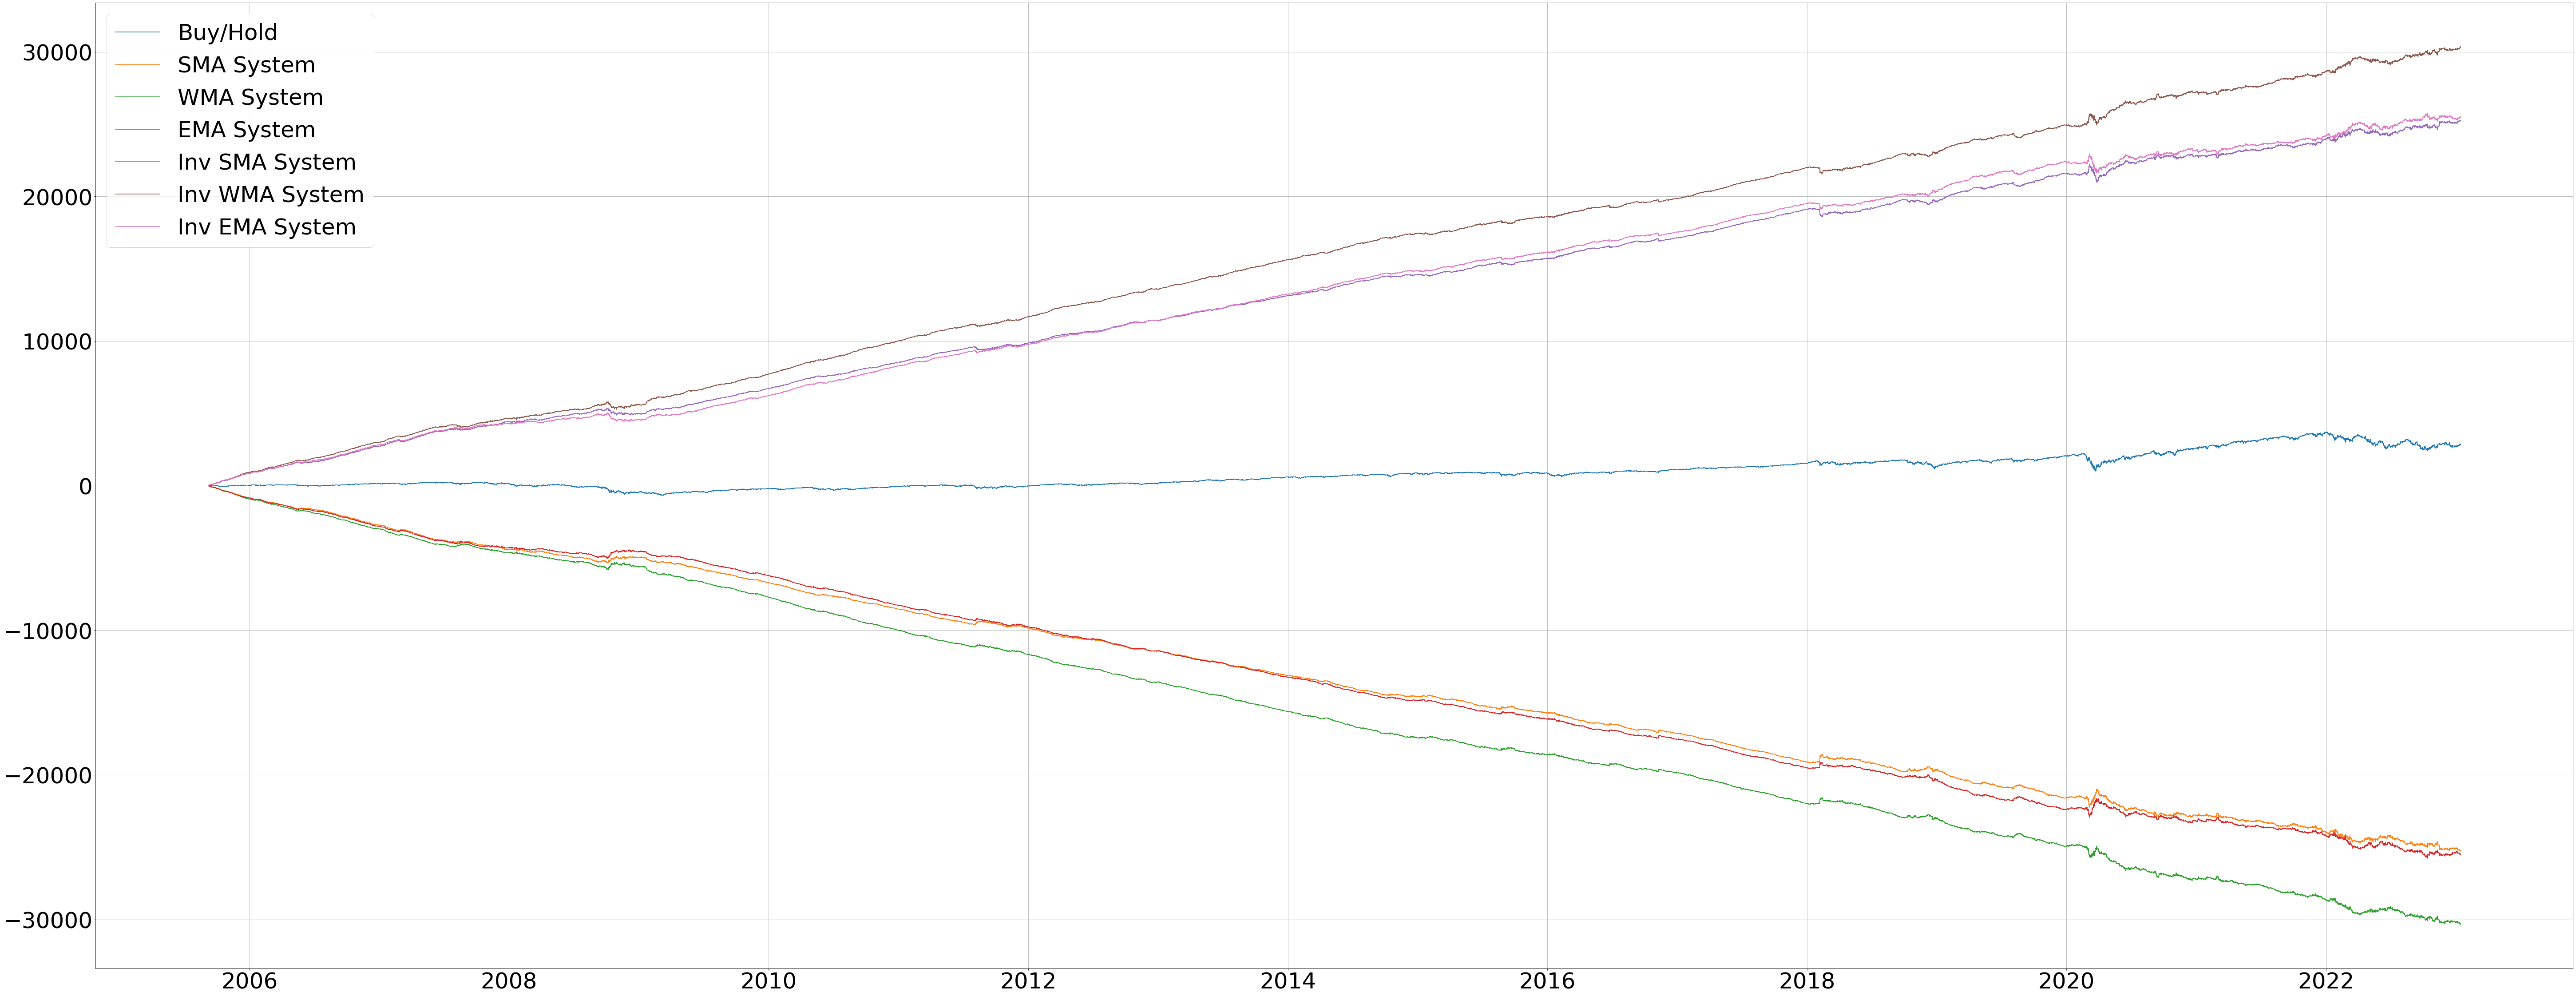

In [49]:
plt.rcParams.update({'font.size': 50})
plt.rcParams['figure.figsize'] = 100,40
plt.plot(np.cumsum(ES['movement']), label = 'Buy/Hold')
plt.plot(np.cumsum(ES['sma_point_profit']), label = 'SMA System')
plt.plot(np.cumsum(ES['wma_point_profit']), label = 'WMA System')
plt.plot(np.cumsum(ES['ema_point_profit']), label = 'EMA System')
plt.plot(np.cumsum(ES['inv_sma_point_profit']), label = 'Inv SMA System')
plt.plot(np.cumsum(ES['inv_wma_point_profit']), label = 'Inv WMA System')
plt.plot(np.cumsum(ES['inv_ema_point_profit']), label = 'Inv EMA System')
plt.legend(loc = 2)
plt.grid()

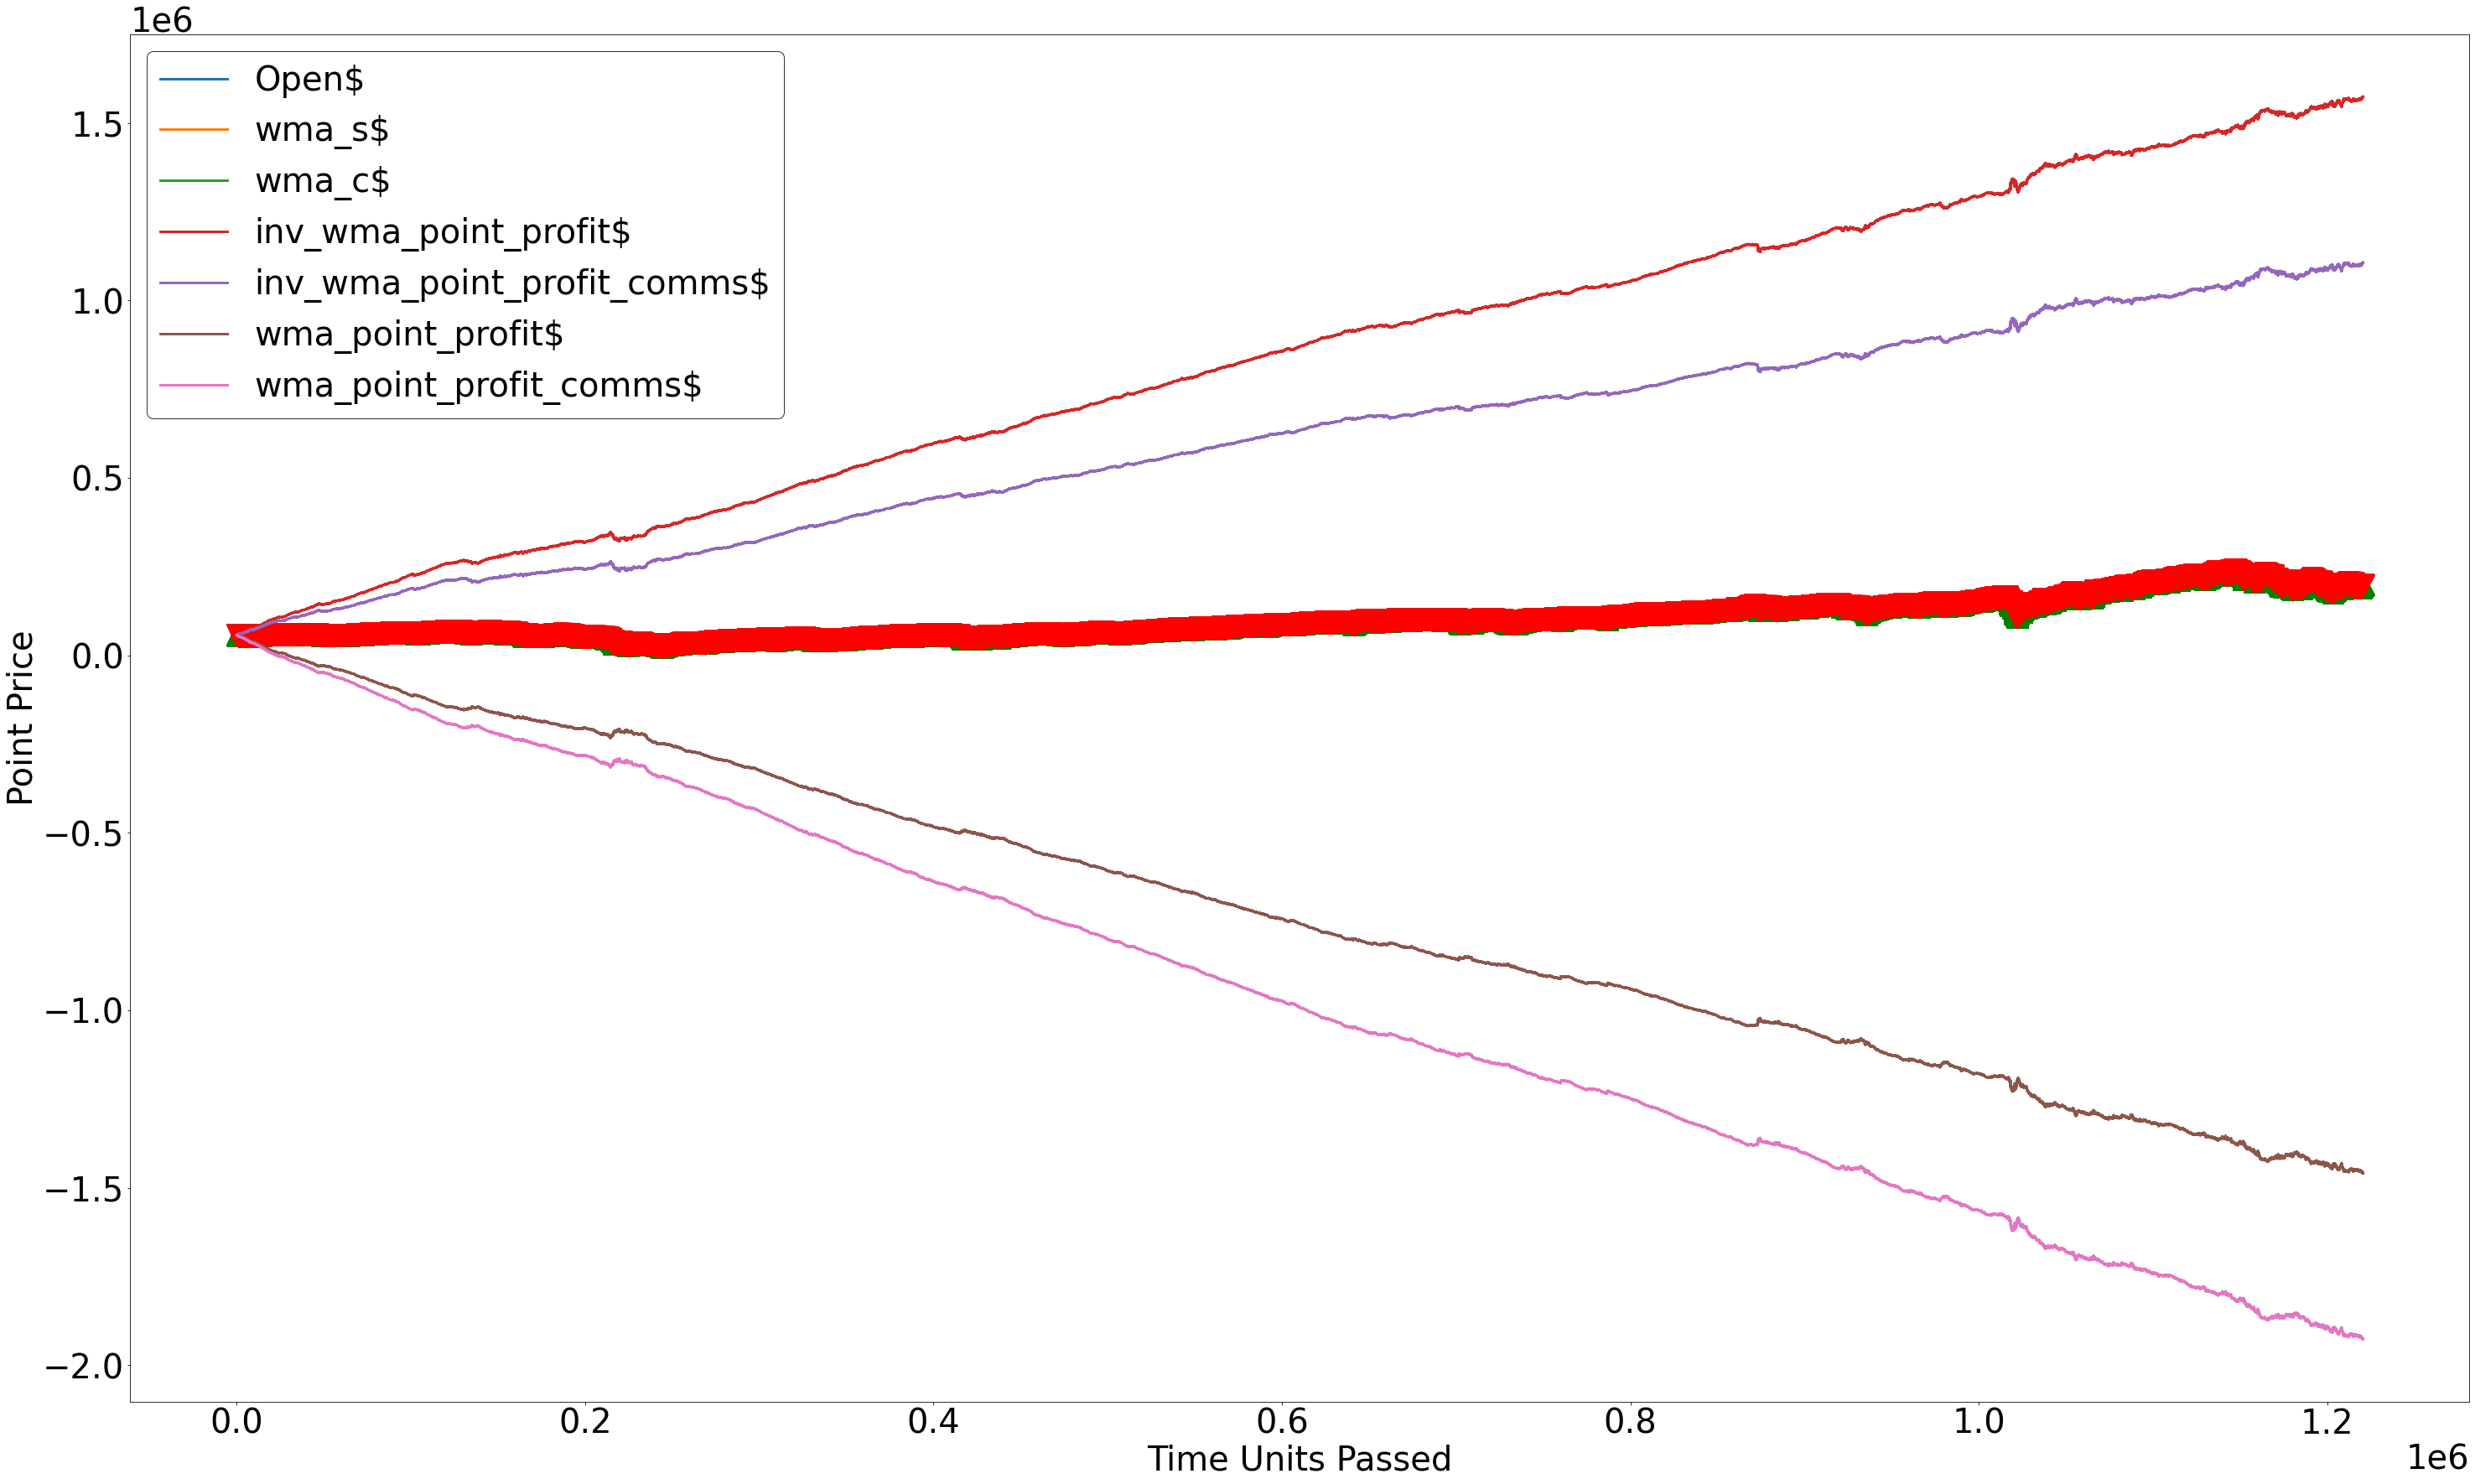

In [50]:
# Visualizing the conventional and inverse wma strategies before commissions and after commissions at dollar value
ES_visual(ES_viz, 'Open$', 'wma_entry', 'wma_s$', 'wma_c$', 'inv_wma_point_profit$', 'inv_wma_point_profit_comms$', 'wma_point_profit$', 'wma_point_profit_comms$')

# Max Draw Down

### This section explores max draw downs for many different window lengths (of time)

In [51]:
# This cell calculates max draw down over different time periods (windows)
ESdd = ES.copy()

ma_names = ['sma', 'wma', 'ema']
max_window = 100006
window_size = 200
starting_point = 5

drawdown_windows = list(range(starting_point, max_window, window_size))
maxdd_colnames = []

for ma in ma_names :
    for win in drawdown_windows :
        ESdd[f"inv_{ma}_point_profit_comms$_maxdd{win}"] = ESdd[f"inv_{ma}_point_profit_comms$"].rolling(win).sum()
        maxdd_colnames.append(f"inv_{ma}_point_profit_comms$_maxdd{win}")
# print(maxdd_colnames)
# ES[500:550]

In [52]:
max_drawdowns = pd.DataFrame(columns=['Window','Max Draw Down'])

for name in maxdd_colnames:
    max_drawdowns = max_drawdowns.append({'Window': name, 'Max Draw Down': ESdd[name].min()}, ignore_index=True)
    
# Divide the DataFrame into three equal parts
maxdds_parts = np.array_split(max_drawdowns, 3)

# Access each part separately
maxdd_sma = maxdds_parts[0]
maxdd_wma = maxdds_parts[1]
maxdd_ema = maxdds_parts[2]

In [53]:
print('SMA')
print(maxdd_sma)
print()
print('WMA')
print(maxdd_wma)
print()
print('EMA')
print(maxdd_ema)

SMA
                                      Window Max Draw Down
0         inv_sma_point_profit_comms$_maxdd5     -7675.000
1       inv_sma_point_profit_comms$_maxdd205    -16123.380
2       inv_sma_point_profit_comms$_maxdd405    -22278.580
3       inv_sma_point_profit_comms$_maxdd605    -22125.820
4       inv_sma_point_profit_comms$_maxdd805    -26846.140
..                                       ...           ...
496   inv_sma_point_profit_comms$_maxdd99205     18602.200
497   inv_sma_point_profit_comms$_maxdd99405     17879.260
498   inv_sma_point_profit_comms$_maxdd99605     17786.300
499   inv_sma_point_profit_comms$_maxdd99805     17347.100
500  inv_sma_point_profit_comms$_maxdd100005     17343.520

[501 rows x 2 columns]

WMA
                                       Window Max Draw Down
501        inv_wma_point_profit_comms$_maxdd5     -7675.000
502      inv_wma_point_profit_comms$_maxdd205    -14582.560
503      inv_wma_point_profit_comms$_maxdd405    -20605.240
504      inv_wma_po

In [54]:
maxdd_ma_names = ['maxdd_sma', 'maxdd_wma', 'maxdd_ema']

def maxddviz(maxdd) :
    maxdd['Window#'] = maxdd['Window'].str.extract(r'(\d+)').astype(int)

    # Plot line graph
    plt.plot(maxdd['Window#'], maxdd['Max Draw Down'], marker='o')

    # Set labels and title
    plt.xlabel('Window#')
    plt.ylabel('Draw Down $')
    plt.title('Line Graph: Window vs. Max Draw Down')
    plt.grid(True, linewidth = 2)

    plt.xticks(rotation='45')

    # Display the plot
    plt.show()

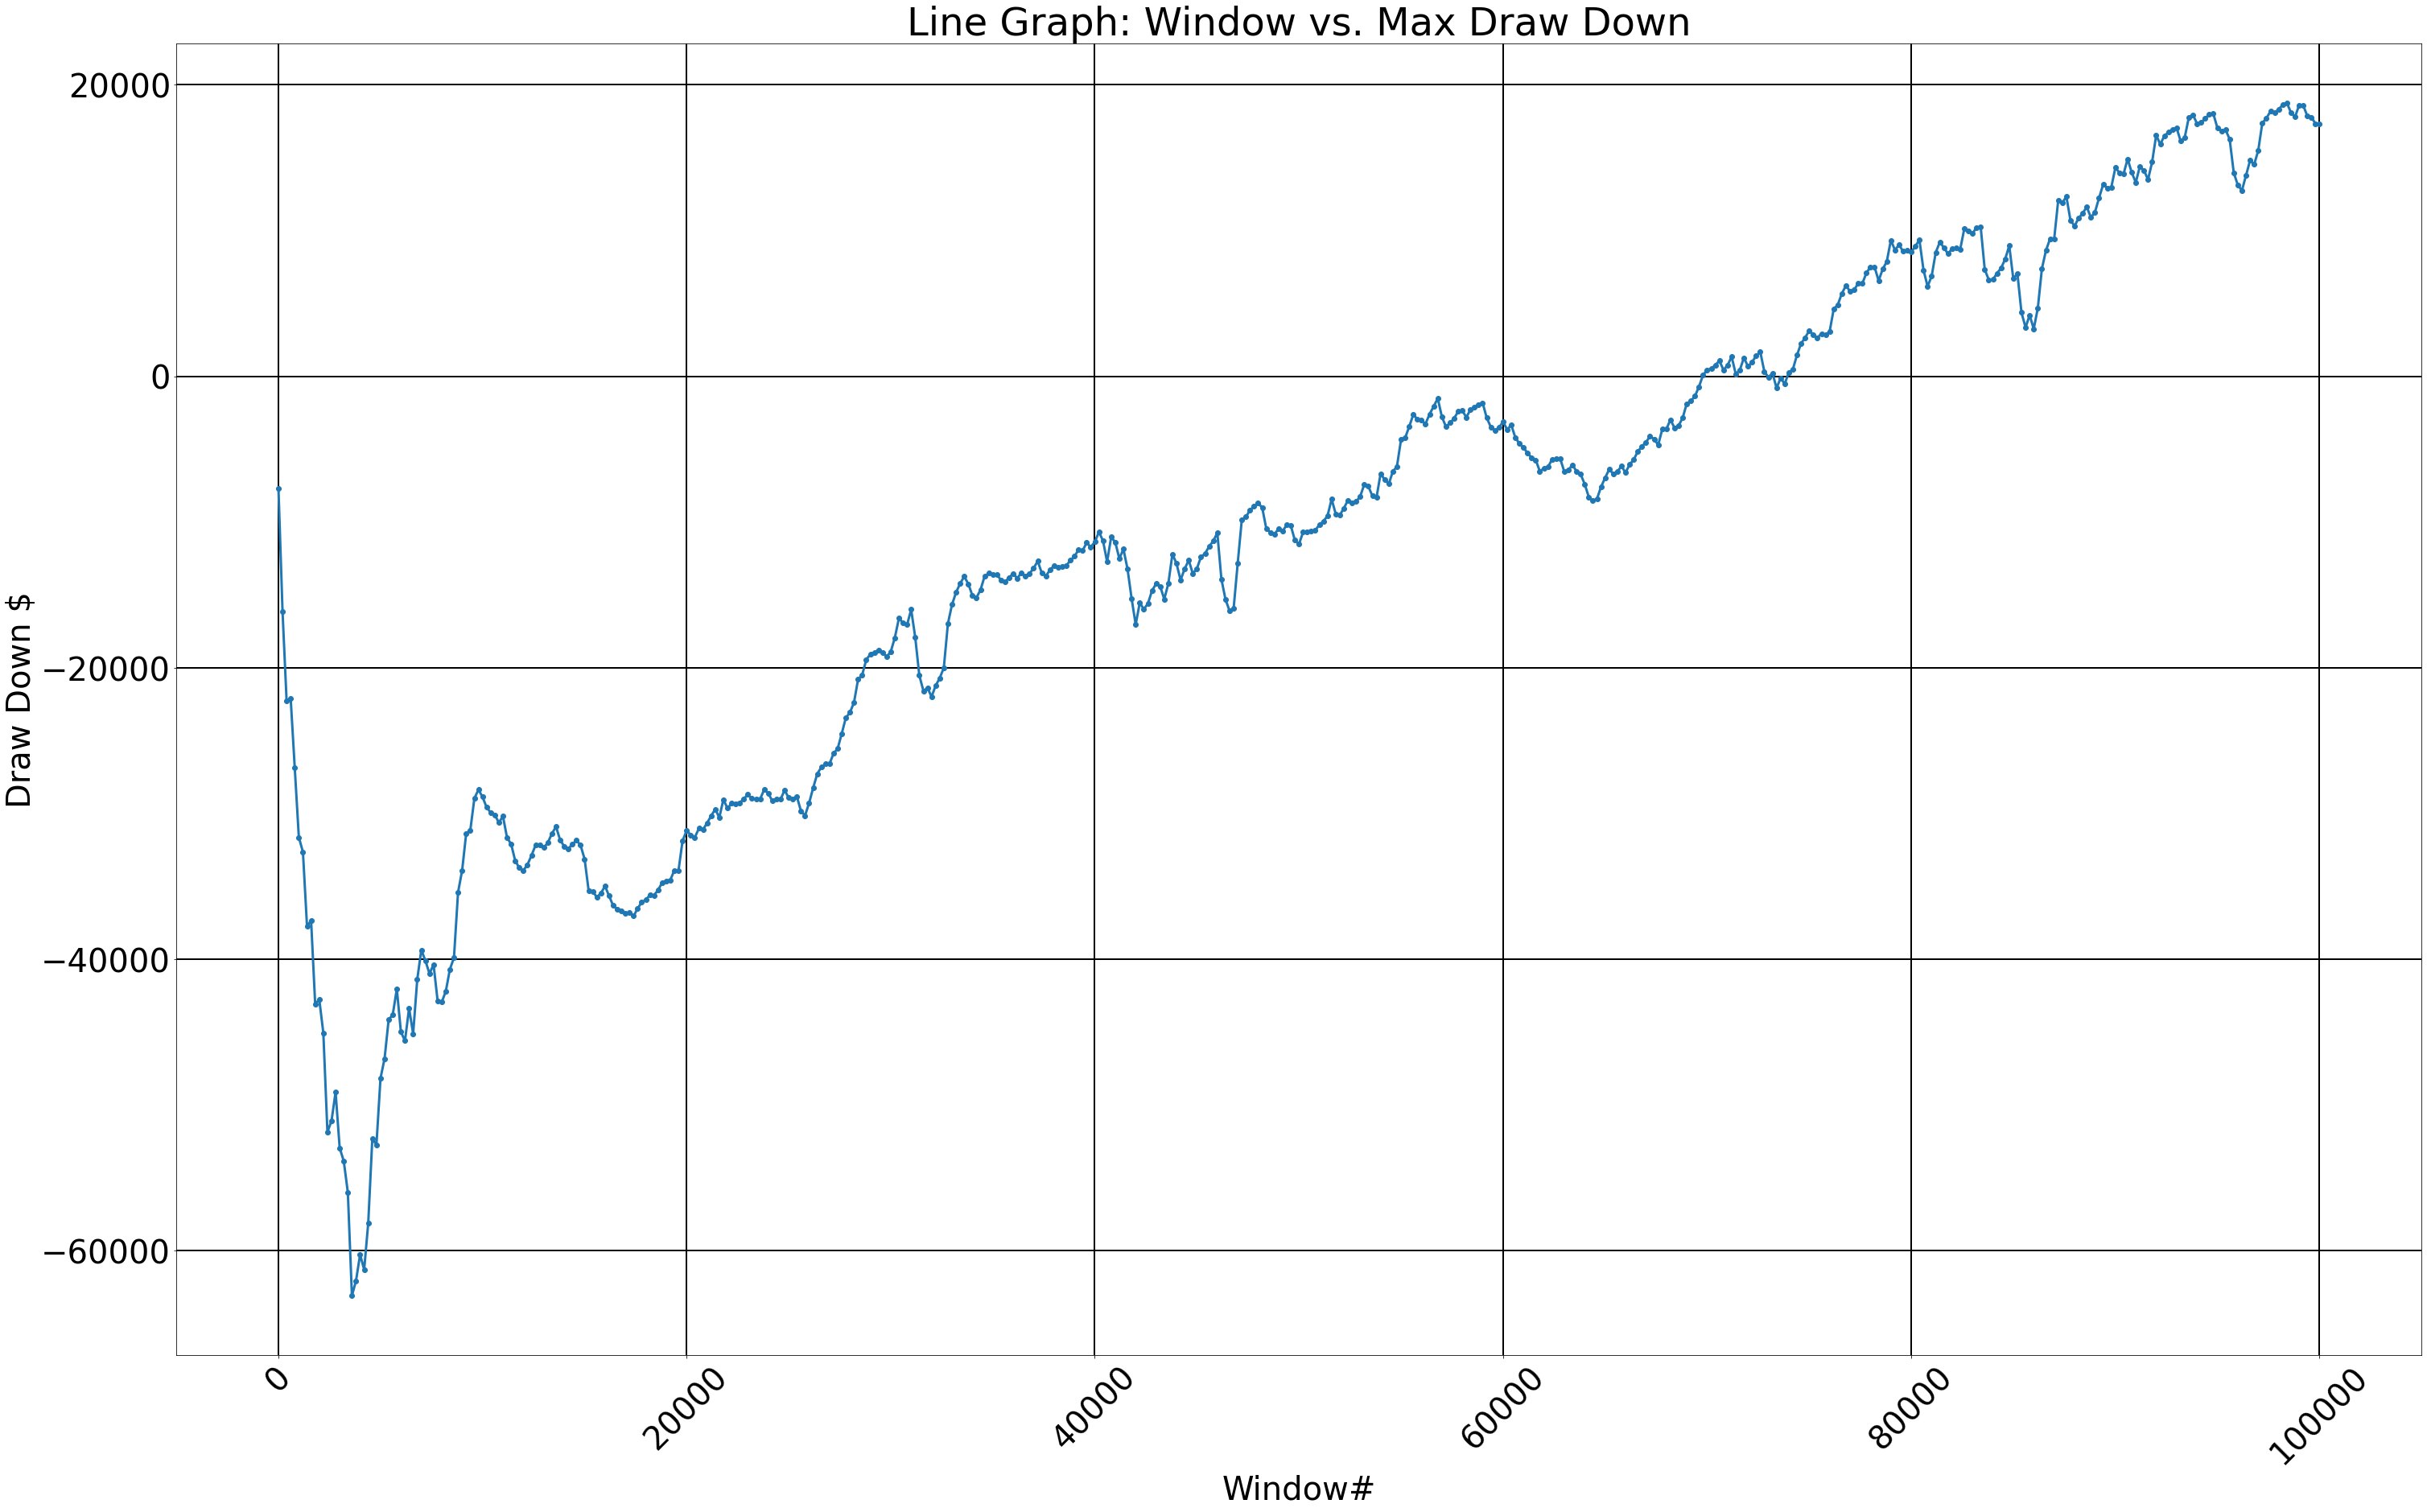

In [55]:
# Visualizing the most this strategy drew down over many windows of time
maxddviz(maxdd_sma)

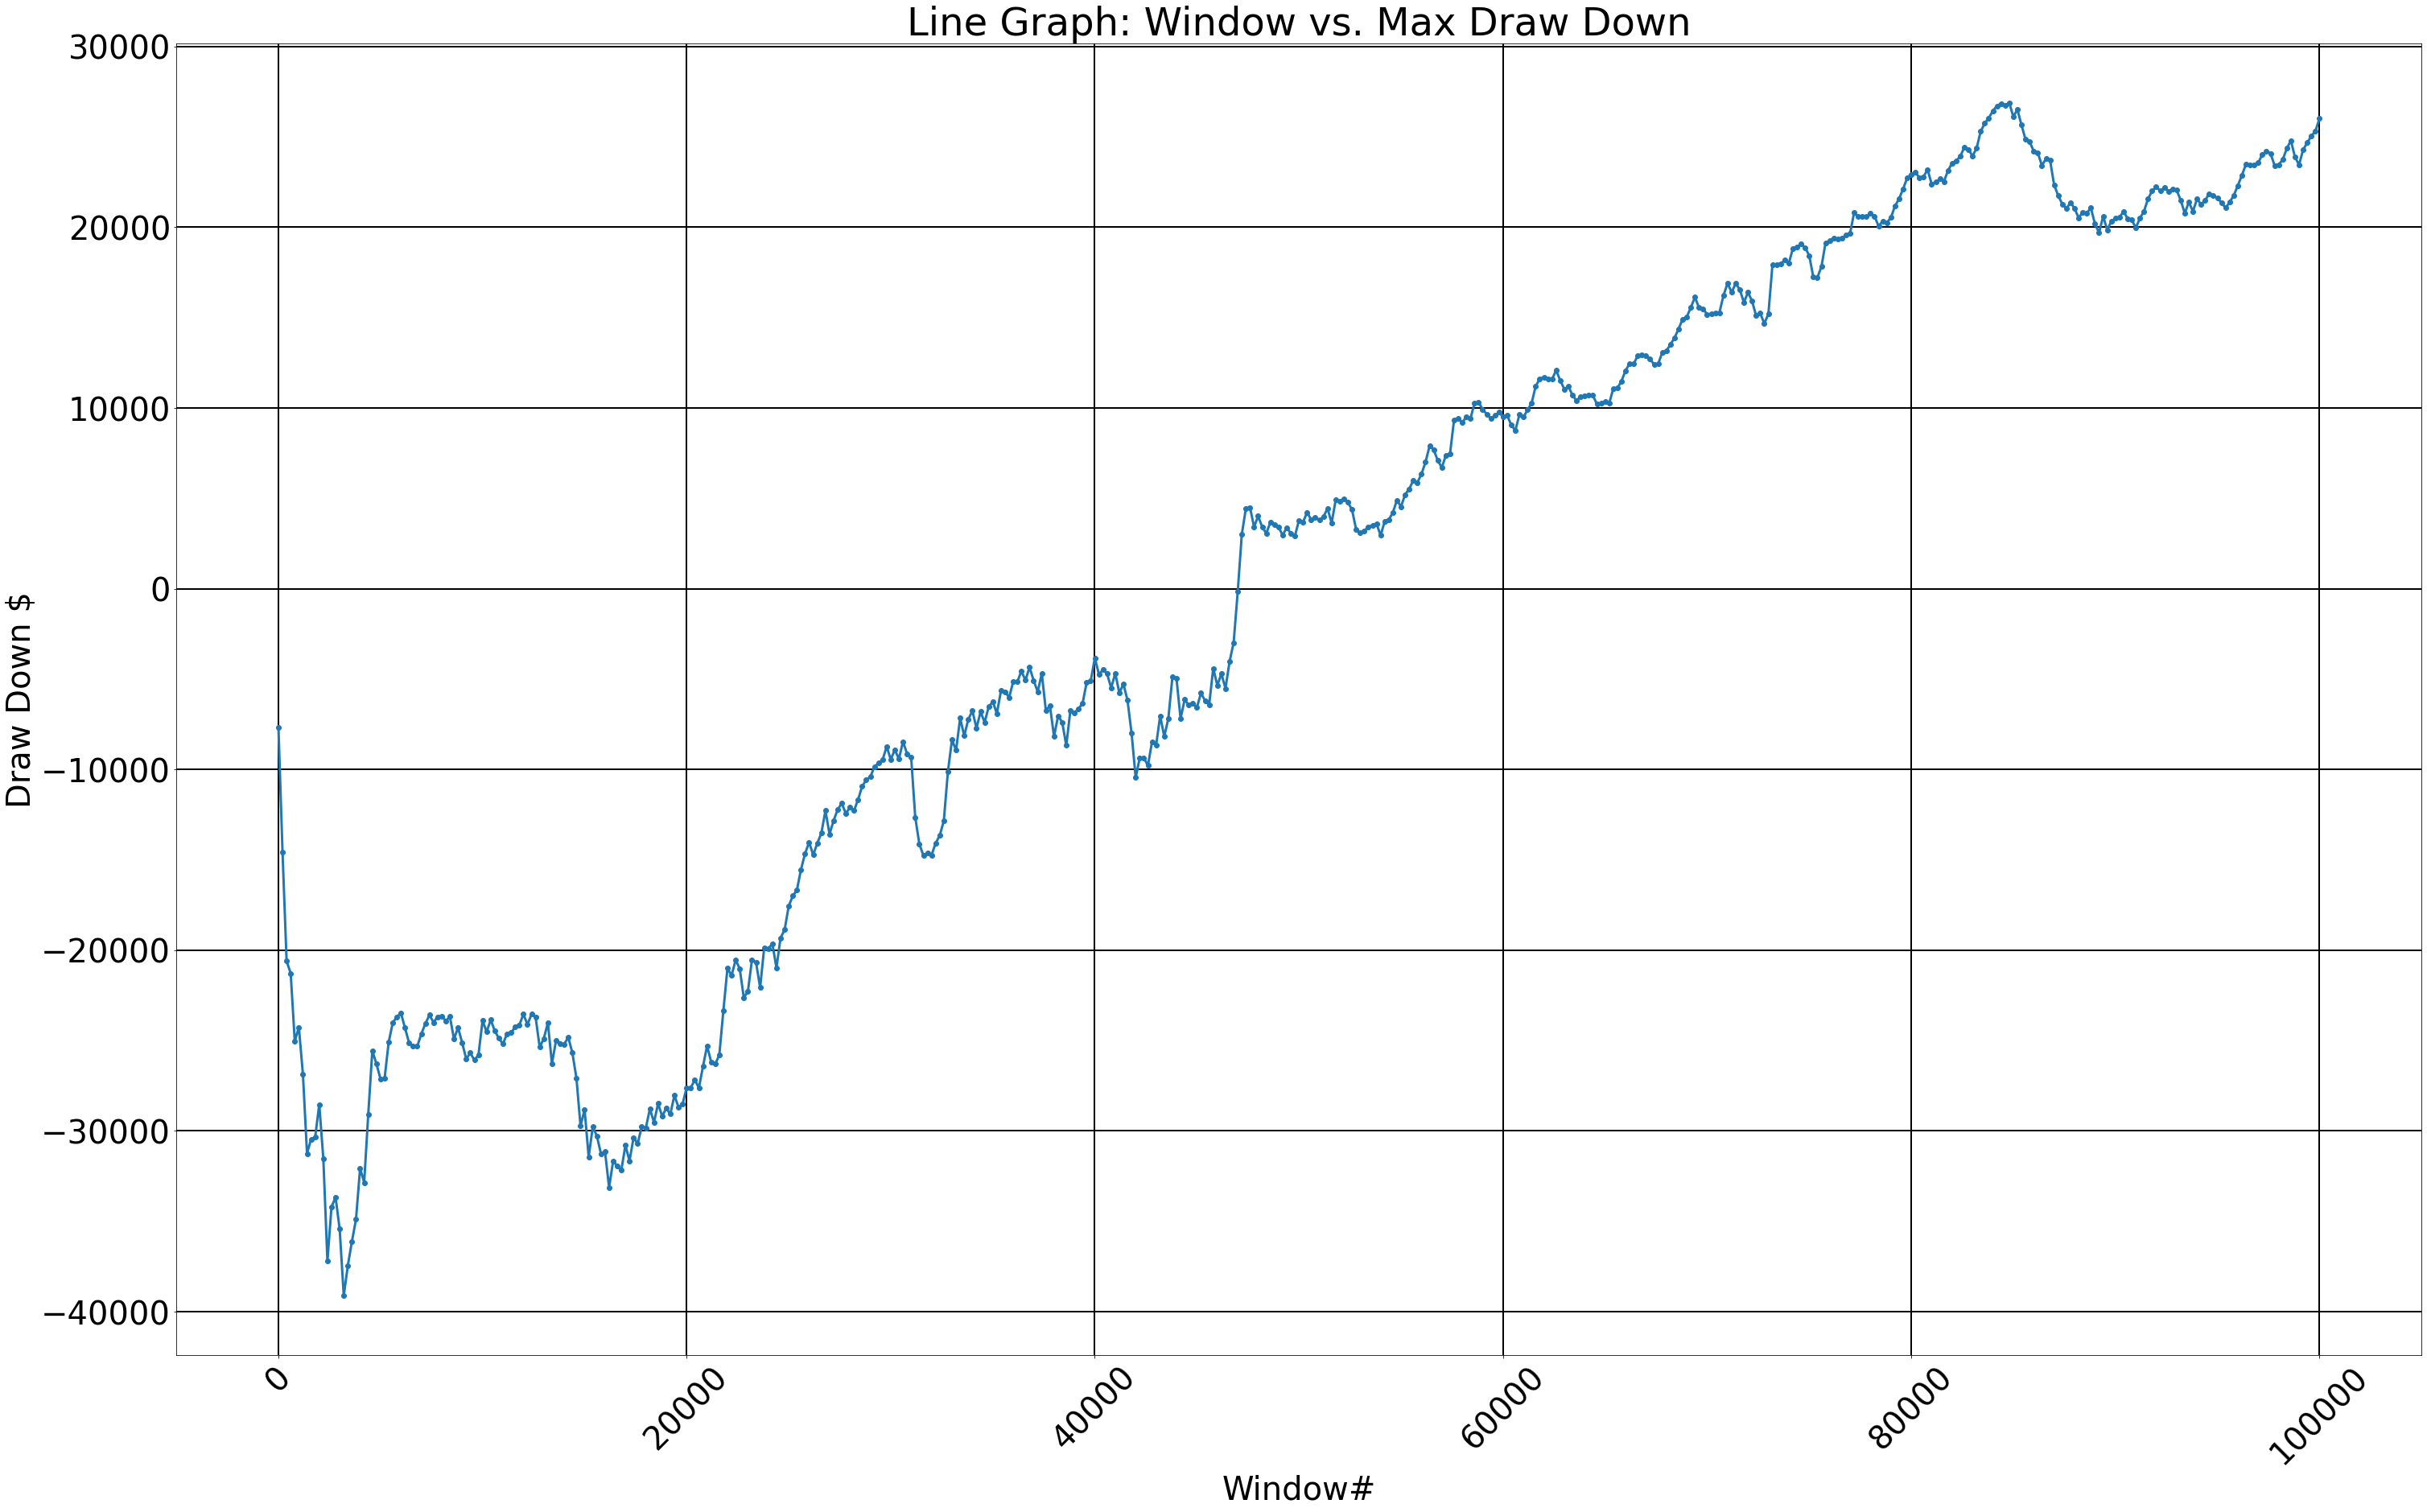

In [56]:
maxddviz(maxdd_wma)

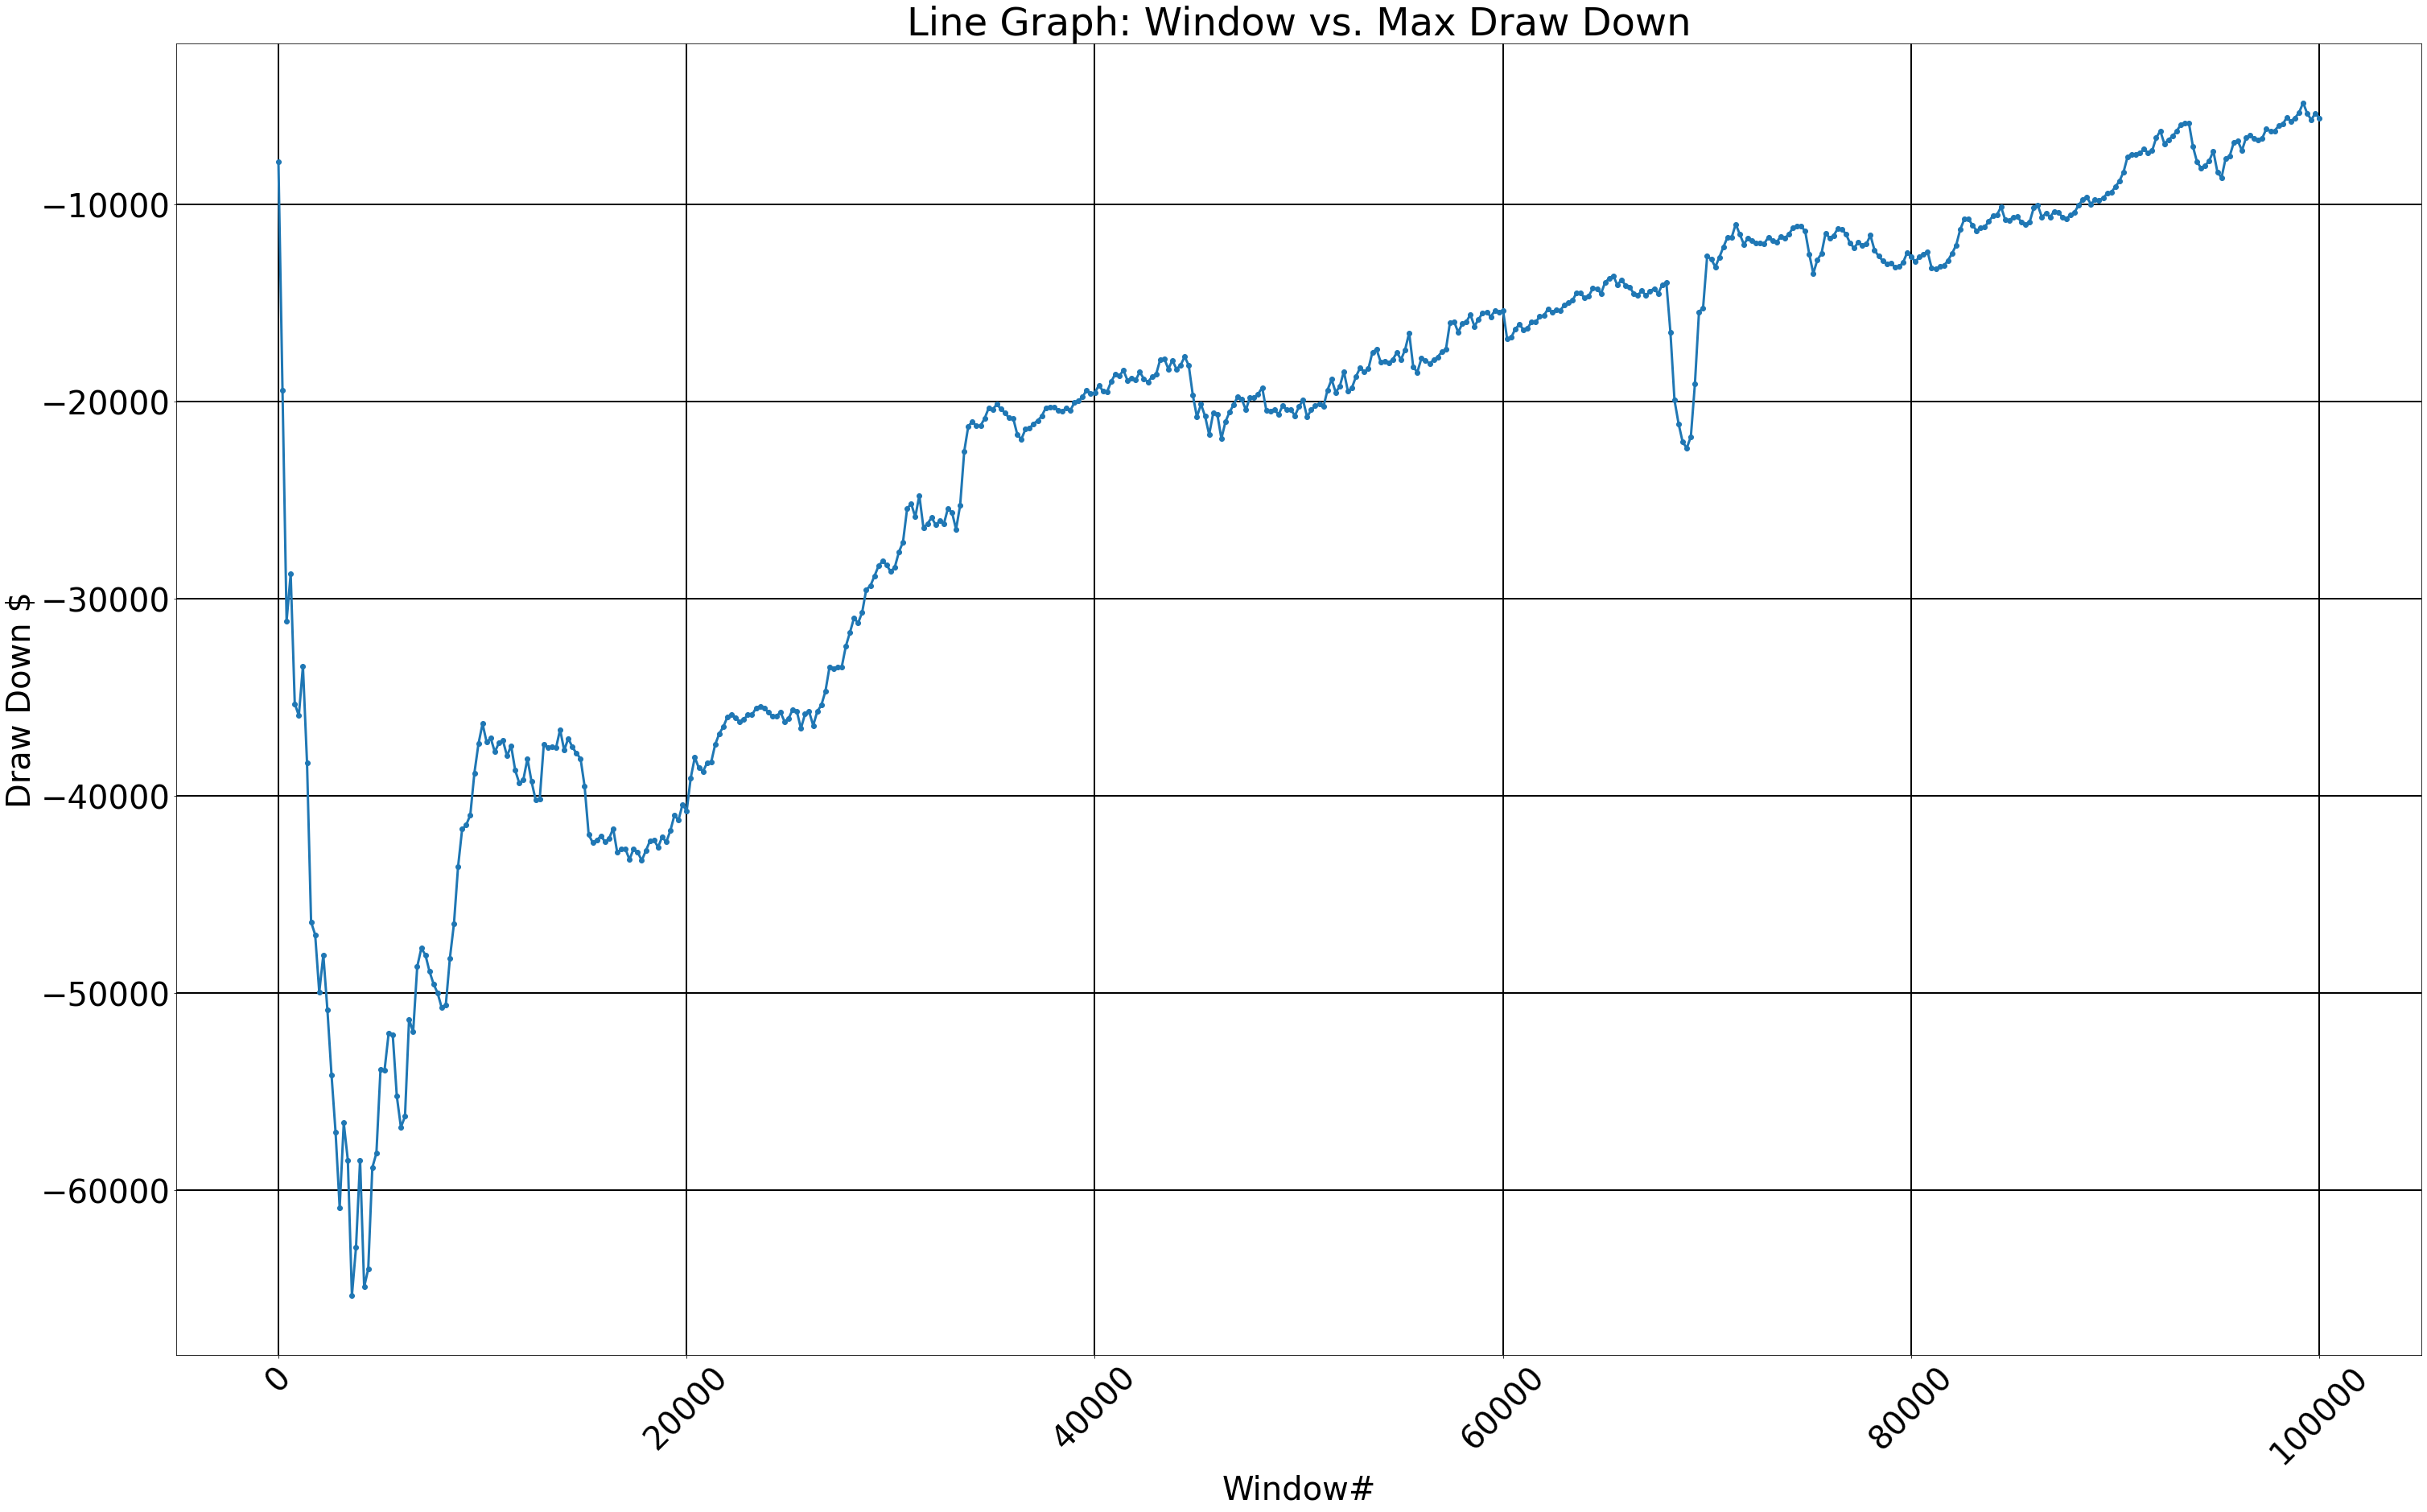

In [57]:
maxddviz(maxdd_ema)

### The next two code blocks are for exploring a particular draw down column in more detail.

In [58]:
window = 50005
minutes = 5

DrawDownCol = ESdd[f'inv_wma_point_profit_comms$_maxdd{window}'].dropna().sort_values()
print(f"The max draw down in {window*minutes} minutes, or about {round(window*minutes/60)} hours, or about {round(window*minutes/60/23)} trading sessions was ${round(DrawDownCol.min())} for inv_wma_point_profit_comms$_maxdd{window}")
DrawDownCol

The max draw down in 250025 minutes, or about 4167 hours, or about 181 trading sessions was $3783 for inv_wma_point_profit_comms$_maxdd50005


Date
2022-12-18 18:35:00    3782.820
2022-12-18 18:45:00    3821.500
2022-12-18 18:50:00    3834.000
2022-12-18 18:40:00    3871.500
2021-03-02 23:20:00    3889.260
                         ...   
2020-12-09 21:00:00   94811.300
2020-12-09 21:15:00   94847.620
2020-12-09 21:05:00   94847.620
2020-12-09 20:40:00   94883.940
2020-12-09 20:35:00   94985.120
Name: inv_wma_point_profit_comms$_maxdd50005, Length: 1170679, dtype: float64

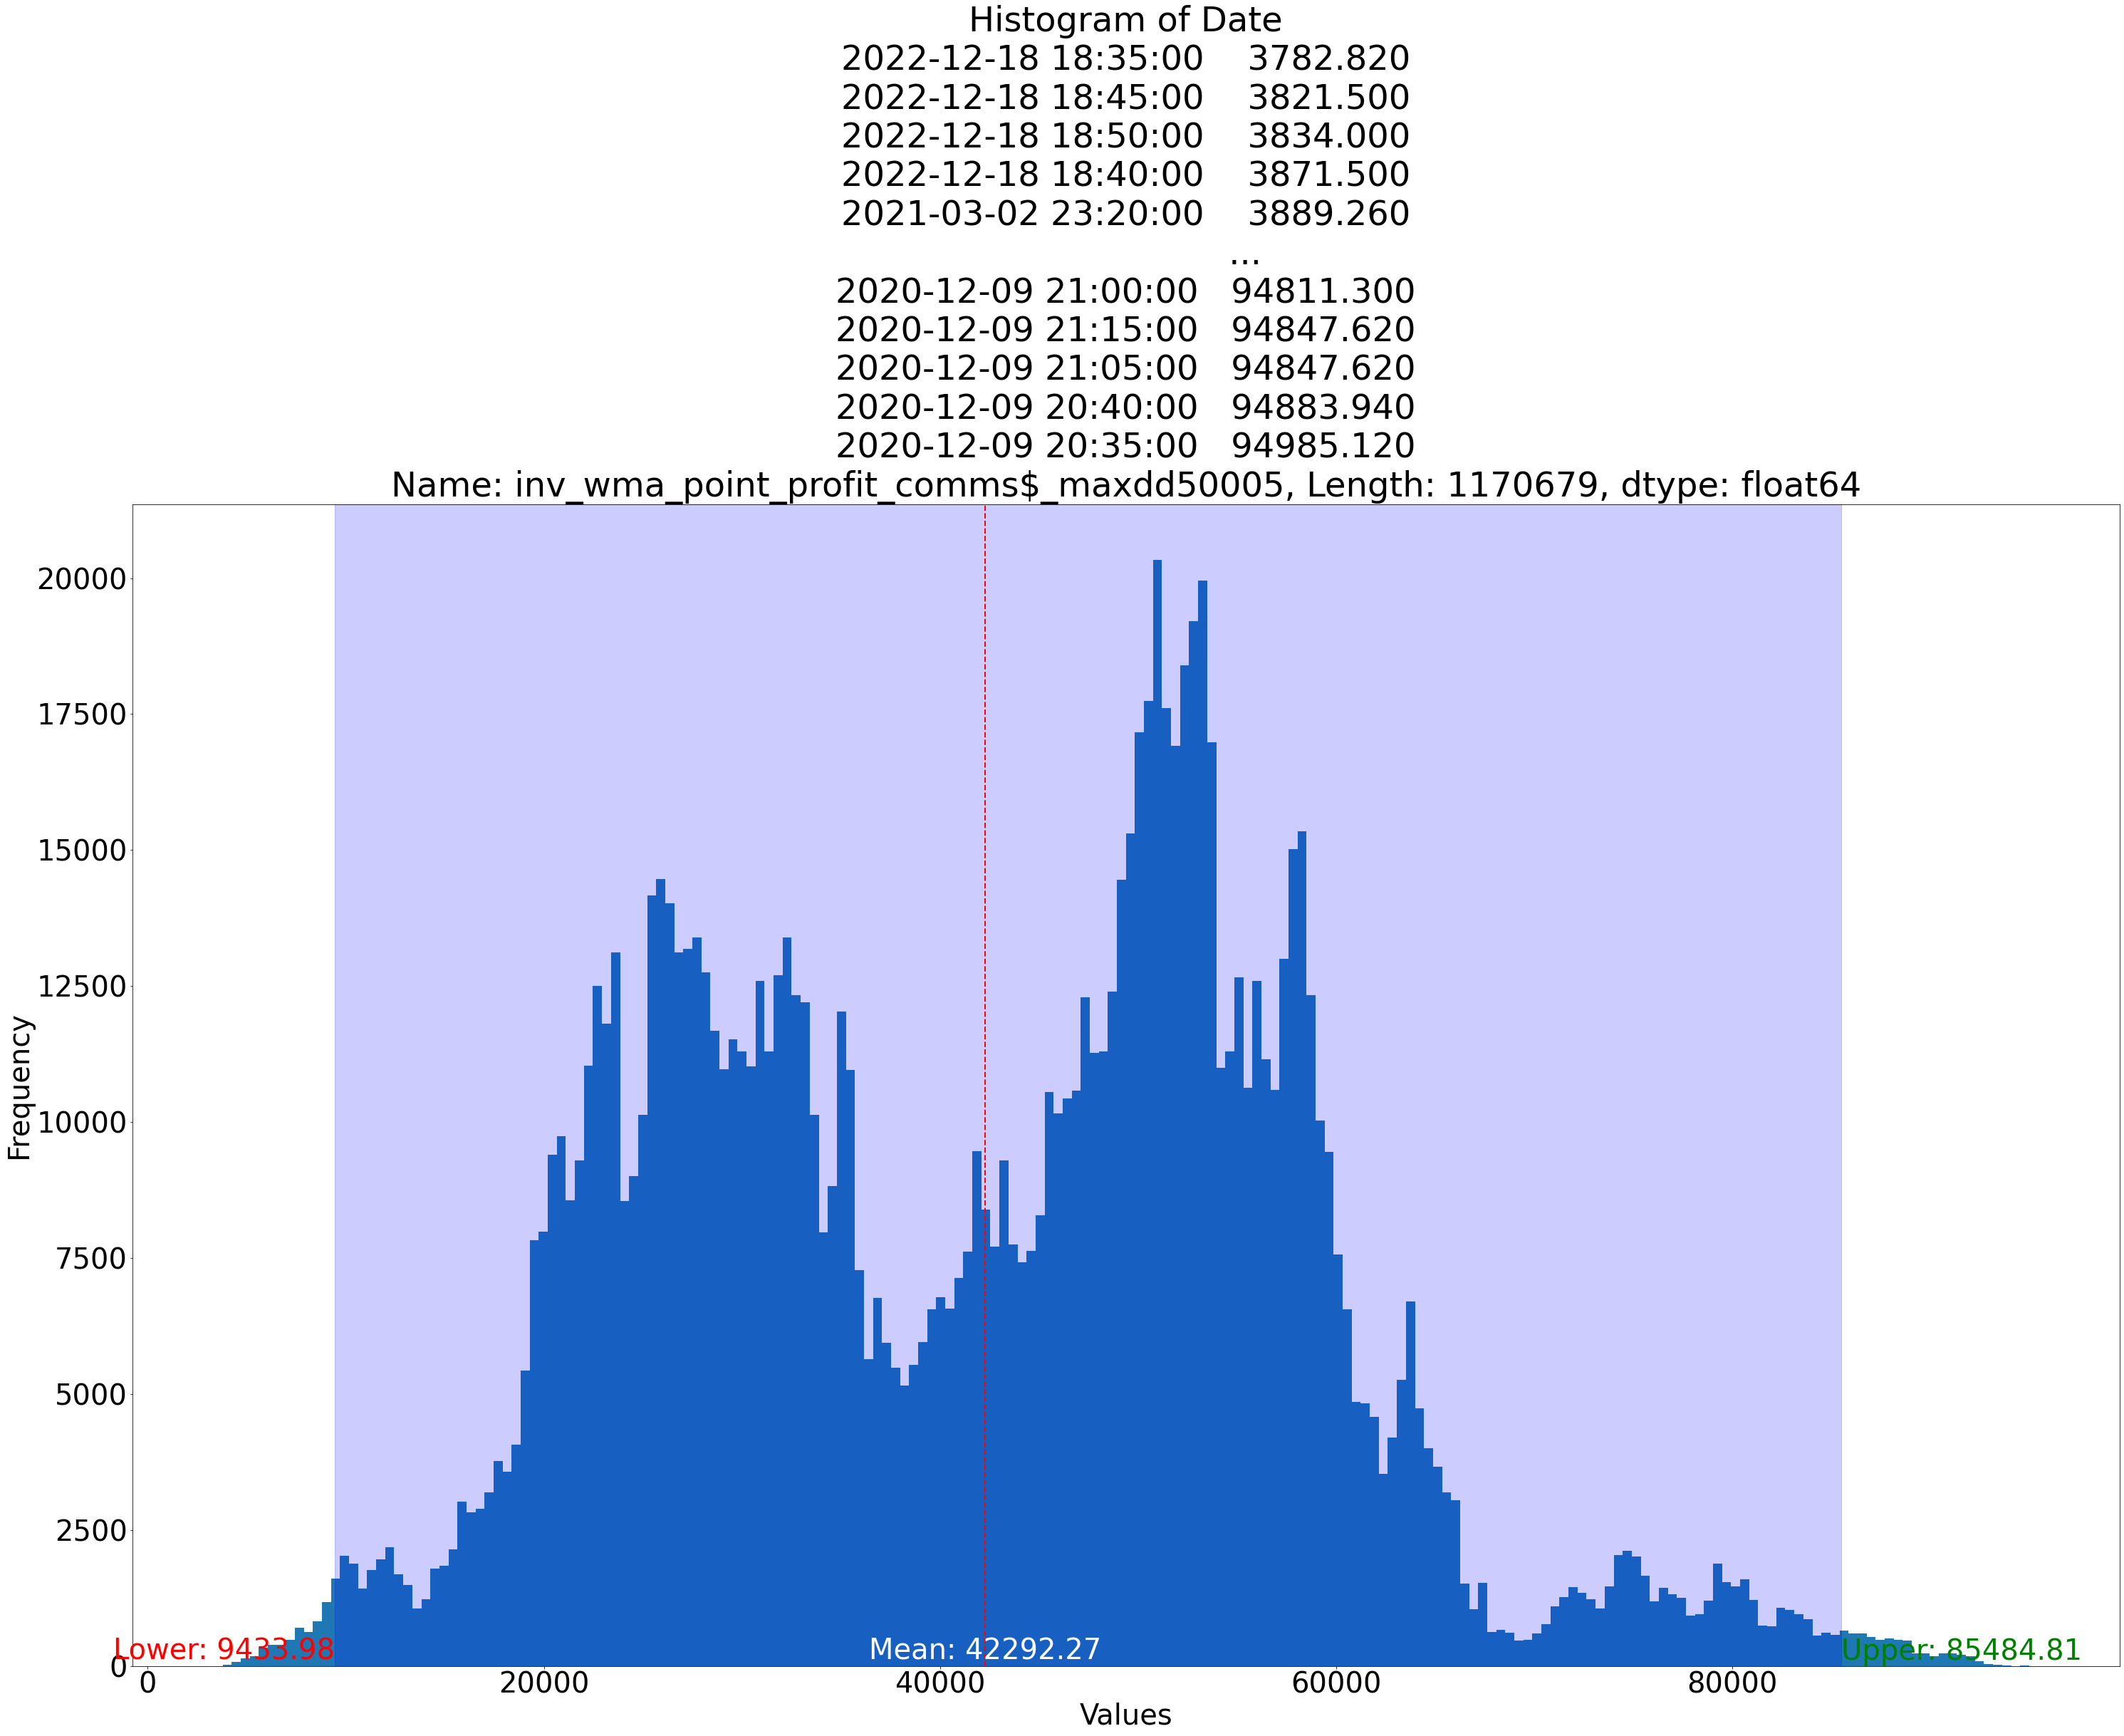

In [59]:
# Plotting a histogram of draw downs in the given period
plt.hist(DrawDownCol, bins = 200)
ddmean = DrawDownCol.mean()
ddstd = DrawDownCol.std()

# Calculate confidence interval
alpha = 0.99  # Confidence level
lower_bound = np.percentile(DrawDownCol, (1 - alpha) / 2 * 100)
upper_bound = np.percentile(DrawDownCol, (1 + alpha) / 2 * 100)

# Set labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title(f"Histogram of {DrawDownCol}")

# Plotting percentile bounds and mean
plt.axvline(ddmean, color='red', linestyle='--', linewidth=2)
plt.text(ddmean, plt.ylim()[0], f'Mean: {ddmean:.2f}', color='white', ha='center', va='bottom')
plt.axvspan(lower_bound, upper_bound, color='blue', alpha=0.2)

plt.text(lower_bound, plt.ylim()[0], f'Lower: {lower_bound:.2f}', color='red', ha='right', va='bottom')
plt.text(upper_bound, plt.ylim()[0], f'Upper: {upper_bound:.2f}', color='green', ha='left', va='bottom')

# Display the histogram
plt.show()

# Exploratory Analysis

This next section explores some features of the data that were created early on in the script. Such features include candle body, which will be used to calculate a rolling measure of noise, and candle body, which is the distance from a candle's open to its close. Movement is very similar to candle body in nature, but not exactly the same since there can be jumps from a prior close to the next open.

### Movement

In [60]:
ES['movement'].describe()

count   1220683.000
mean          0.002
std           1.639
min        -100.750
25%          -0.500
50%           0.000
75%           0.500
max          91.500
Name: movement, dtype: float64

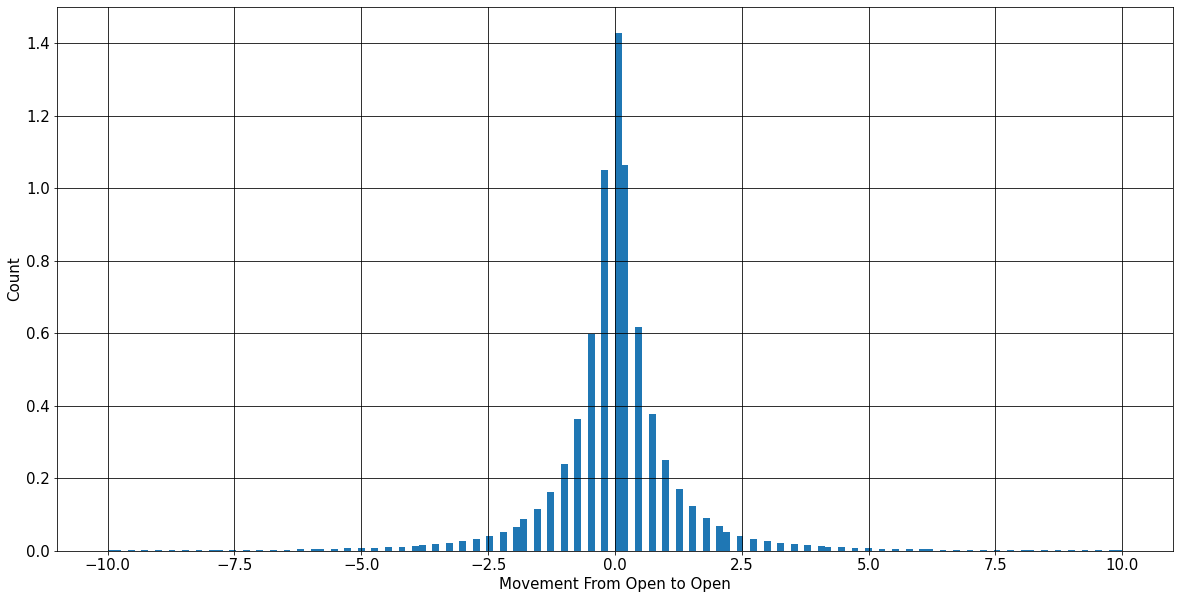

In [110]:
plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(figsize =(20, 10))
axis.hist(ES['movement'], bins = 150, range = (-10,10), 
          density = True, log = False)
plt.ylabel('Count')
plt.xlabel('Movement From Open to Open')
plt.grid(True)
# Displaying the graph
plt.show()

### Span

In [62]:
ES['span'].describe()

count   1220683.000
mean          1.665
std           2.113
min           0.000
25%           0.500
50%           1.000
75%           2.000
max         119.500
Name: span, dtype: float64

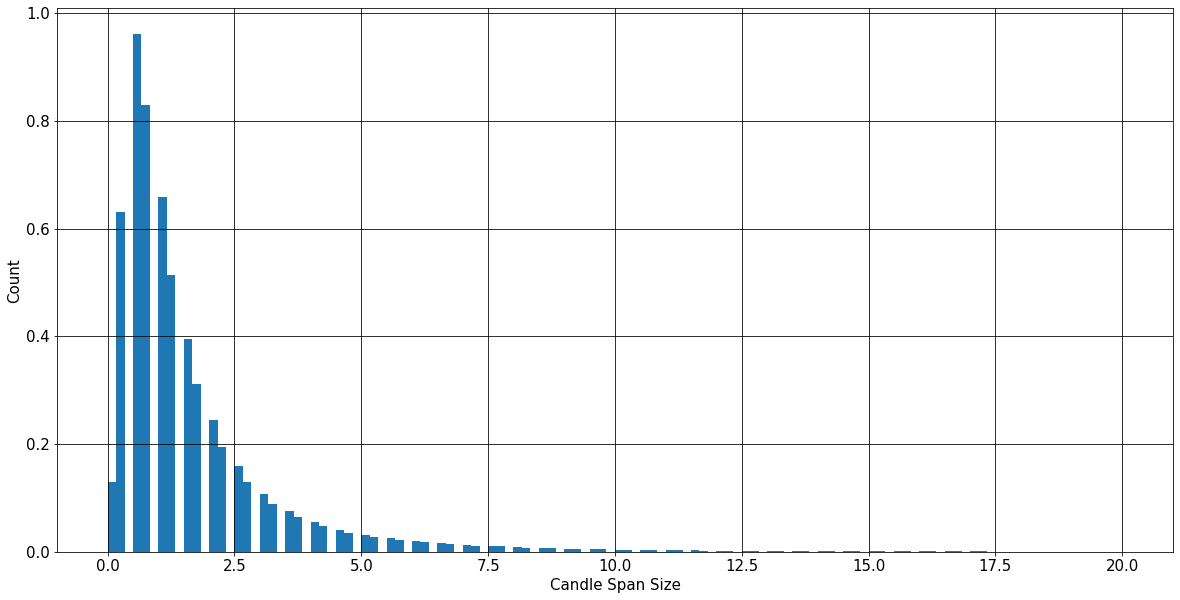

In [111]:
plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(figsize =(20, 10))
axis.hist(ES['span'], bins = 120, range = (0,20), density = True, log = False)
plt.ylabel('Count')
plt.xlabel('Candle Span Size')
plt.grid(True)
# Displaying the graph
plt.show()

### Body

In [64]:
ES['body'].describe()

count   1220683.000
mean          0.821
std           1.394
min           0.000
25%           0.250
50%           0.500
75%           1.000
max         100.750
Name: body, dtype: float64

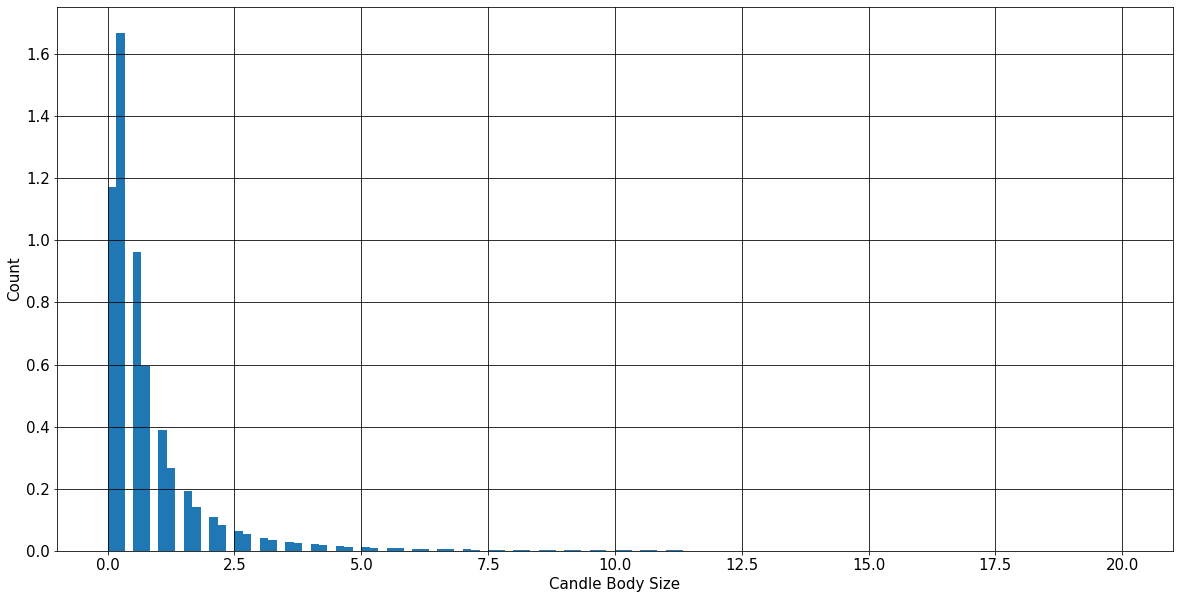

In [112]:
plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(figsize =(20, 10))
axis.hist(ES['body'], bins = 120, range = (0,20), density = True, log = False)
plt.ylabel('Count')
plt.xlabel('Candle Body Size')
plt.grid(True)
# Displaying the graph
plt.show()

### Volume

In [66]:
ES['Volume'].describe()

count   1220683.000
mean       5925.160
std       11032.162
min           1.000
25%         359.000
50%        1243.000
75%        6579.000
max      276094.000
Name: Volume, dtype: float64

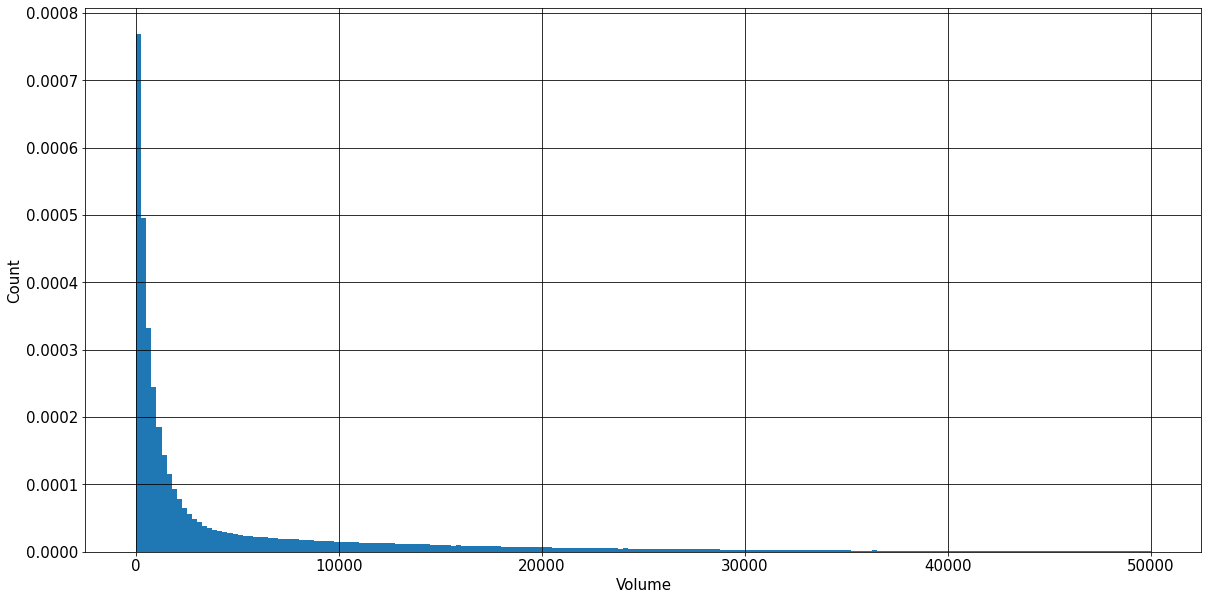

In [113]:
plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(figsize =(20, 10))
axis.hist(ES['Volume'], bins = 200, range = (0,50000), density = True, log = False)
plt.ylabel('Count')
plt.xlabel('Volume')
plt.grid(True)
# Displaying the graph
plt.show()

### Vol-VMA

In [68]:
ES['vol-vma'].describe()

count   1220683.000
mean          0.004
std        7062.786
min      -93459.700
25%        -615.600
50%         -70.600
75%         322.150
max      230278.600
Name: vol-vma, dtype: float64

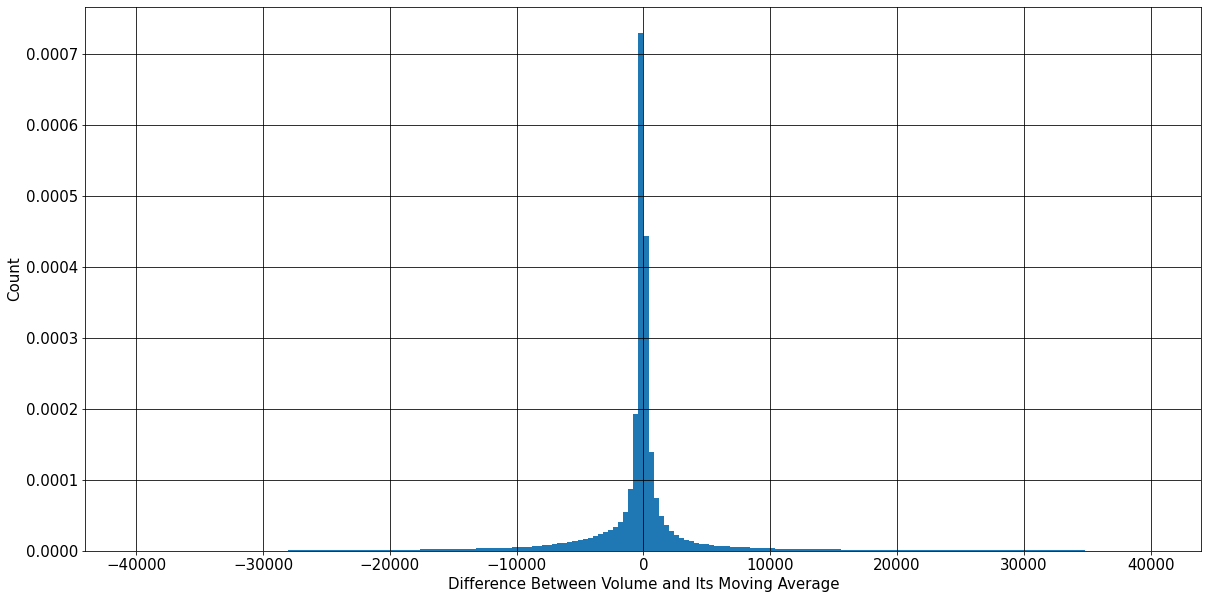

In [114]:
plt.rcParams.update({'font.size': 15})
fig, axis = plt.subplots(figsize =(20, 10))
axis.hist(ES['vol-vma'], bins = 200, range = (-40000,40000), 
          density = True, log = False)
plt.ylabel('Count')
plt.xlabel('Difference Between Volume and Its Moving Average')
plt.grid(True)
# Displaying the graph
plt.show()

In [70]:
ES.columns

Index(['Open', 'High', 'Low', 'Close', 'Mean', 'Volume', 'Time_Unit', 'span',
       'body', 'vma', 'vol-vma', 'day_shift', 'mean_shift', 'mean_slope',
       'open_shift', 'open_slope', 'sma_s', 'inv_signal', 'signal', 'sma_c',
       'wma_s', 'inv_signal2', 'signal2', 'wma_c', 'ema_s', 'inv_signal3',
       'signal3', 'ema_c', 'movement', 'sma_point_profit', 'wma_point_profit',
       'ema_point_profit', 'inv_sma_point_profit', 'inv_wma_point_profit',
       'inv_ema_point_profit', 'sma_entry', 'wma_entry', 'ema_entry',
       'abs_sma_entry', 'abs_wma_entry', 'abs_ema_entry', 'sma_point_profit$',
       'wma_point_profit$', 'ema_point_profit$', 'inv_sma_point_profit$',
       'inv_wma_point_profit$', 'inv_ema_point_profit$', 'sma_comms',
       'wma_comms', 'ema_comms', 'sma_point_profit_comms',
       'wma_point_profit_comms', 'ema_point_profit_comms',
       'inv_sma_point_profit_comms', 'inv_wma_point_profit_comms',
       'inv_ema_point_profit_comms', 'sma_point_profit_comms$',


In [71]:
# THINGS TO WORK ON
# 3.COULD DO A MEAN TEST ON THE DISTANCE BETWEEN EACH MA AND PRICE TO CONFIRM THAT SHORTER PERIOD MAS STAY CLOSER TO PRICE
# 8.LEARN HOW TO USE A TRADING API
# 9.LEARN TO USE JAVASCRIPT/C# IF NECESSARY
# 10.REALLY NEED TO THINK ABOUT HOW TO PREVENT LARGE LOSSES USING THE CONVENTIONAL RULE-----------VVVVVV
# 11.CONSIDER ADDING THE COLUMNS AND ENRICHING THE DATA IN THE WAYS YOU DREAMT ABOUT                VV 
#    -DIFFERENCE BETWEEN SMA & sma_c                                                                V  
#     -THINK ABOUT HOW TO DETECT WHEN CONVENTIONAL RULE SHOULD TAKE OVER (COMBINATION OF VOLUME, SLOPE STABILITY, AND NOISE)
#      -MOVING AVERAGE RIBBON AND SUM OF DIFFERENCE
#       -RSI CALCULATION
#        -LOCAL HIGHS AND LOWS
#         -VWAP CALCULATION
#          -

# Using Mean Slope

#### This next section is a work in progress. The aim here is to develop some measure of slope (which can be changed) based on time distance and determine whether slope somehow correlates with profitability of the given MA strategy. A better measure would be persistence of stability of slope. Even further, it might be prudent to devise a measure that incorporates stability of slope with noise. Noise can be calculated with candle span. A persistent slope with low noise seems ideal for the performance of a moving average crossover strategy.

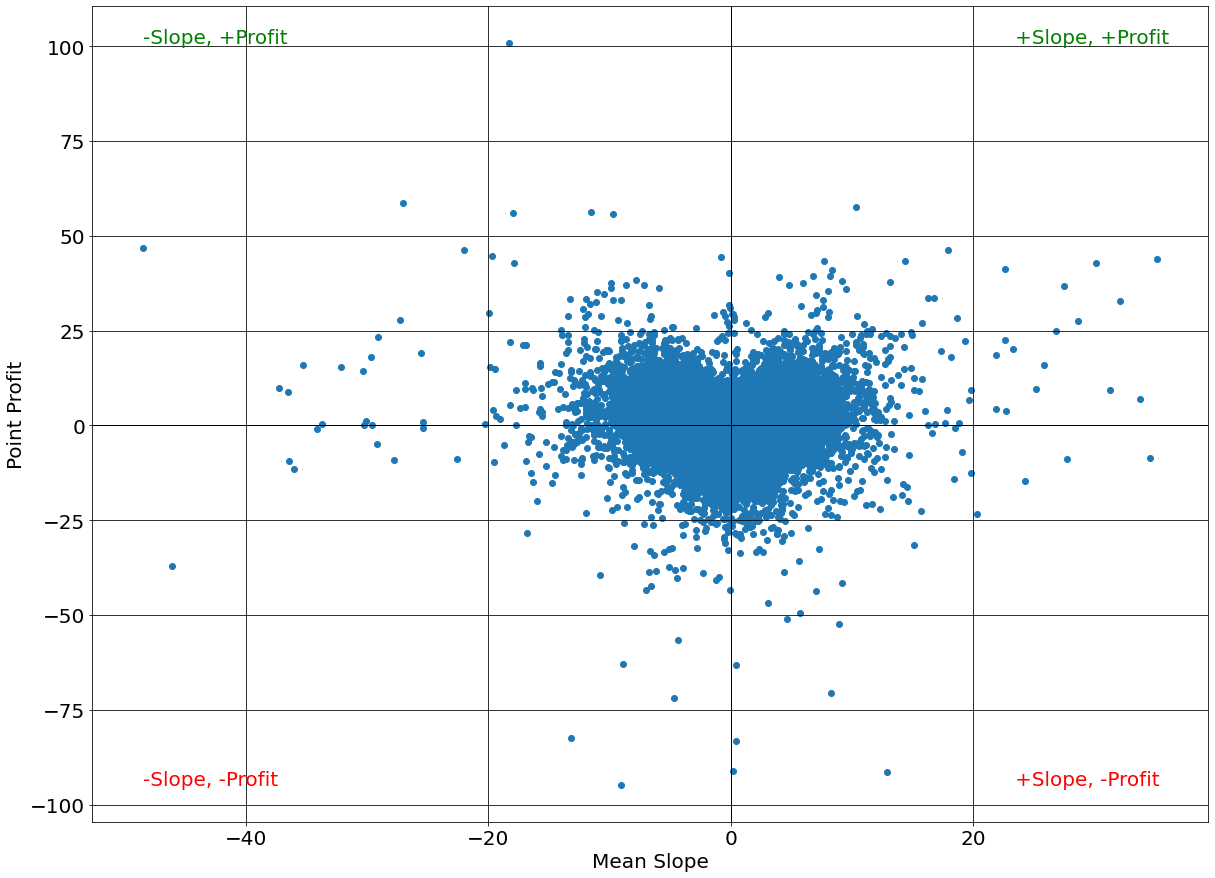

In [72]:
x1 = ES['mean_slope'].max()/1.5
x2 = ES['mean_slope'].min()
y1 = ES['sma_point_profit'].max()
y2 = ES['sma_point_profit'].min()

plt.figure(figsize=(20, 15))
plt.rc('font', size=20)
plt.grid(True)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.scatter(ES['mean_slope'],ES['sma_point_profit'])
plt.xlabel('Mean Slope')
plt.ylabel('Point Profit')
plt.text(x1, y1, '+Slope, +Profit', color='green')
plt.text(x1, y2, '+Slope, -Profit', color='red')
plt.text(x2, y2, '-Slope, -Profit', color='red')
plt.text(x2, y1, '-Slope, +Profit', color='green')
plt.show()

In [73]:
ES.dropna(inplace=True)
tau, pvalue = stats.kendalltau(ES['mean_slope'],ES['sma_point_profit'])

print("Kendall's tau coefficient: {:.3f}".format(tau))
print("p-value: {:.3f}".format(pvalue))

Kendall's tau coefficient: 0.013
p-value: 0.000


In [74]:
ES

,Open,High,Low,Close,Mean,Volume,Time_Unit,span,body,vma,vol-vma,day_shift,mean_shift,mean_slope,open_shift,open_slope,sma_s,inv_signal,signal,sma_c,wma_s,inv_signal2,signal2,wma_c,ema_s,inv_signal3,signal3,ema_c,movement,sma_point_profit,wma_point_profit,ema_point_profit,inv_sma_point_profit,inv_wma_point_profit,inv_ema_point_profit,sma_entry,wma_entry,ema_entry,abs_sma_entry,abs_wma_entry,abs_ema_entry,sma_point_profit$,wma_point_profit$,ema_point_profit$,inv_sma_point_profit$,inv_wma_point_profit$,inv_ema_point_profit$,sma_comms,wma_comms,ema_comms,sma_point_profit_comms,wma_point_profit_comms,ema_point_profit_comms,inv_sma_point_profit_comms,inv_wma_point_profit_comms,inv_ema_point_profit_comms,sma_point_profit_comms$,wma_point_profit_comms$,ema_point_profit_comms$,inv_sma_point_profit_comms$,inv_wma_point_profit_comms$,inv_ema_point_profit_comms$,Open$,sma_s$,sma_c$,wma_s$,wma_c$,ema_s$,ema_c$
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-09-06 17:20:00,1146.500,1146.750,1146.500,1146.500,1146.562,136,11,0.250,0.000,173.500,-37.500,8.000,1146.625,-0.021,1146.500,0.000,1146.500,-1,1,1146.450,1146.500,-1,1,1146.483,1146.500,-1,1,1146.446,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,57325.000,57325.000,57322.500,57325.000,57324.167,57325.000,57322.311
2005-09-06 17:25:00,1146.500,1146.750,1146.500,1146.500,1146.562,68,12,0.250,0.000,123.200,-55.200,9.000,1146.500,0.021,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.464,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-1.000,-1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.012,0.012,0.000,-0.012,-0.012,0.000,-0.012,-0.012,-0.000,-0.590,-0.590,0.000,-0.590,-0.590,-0.000,57325.000,57325.000,57325.000,57325.000,57325.000,57325.000,57323.208
2005-09-06 18:00:00,1146.500,1146.500,1146.250,1146.250,1146.375,107,13,0.250,0.250,120.300,-13.300,10.000,1146.500,-0.042,1146.500,0.000,1146.500,0,0,1146.500,1146.500,0,0,1146.500,1146.500,-1,1,1146.476,-0.250,-0.000,-0.000,-0.250,-0.000,-0.000,0.250,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-12.500,-0.000,-0.000,12.500,0.000,0.000,0.000,-0.000,-0.000,-0.250,-0.000,-0.000,0.250,-0.000,-0.000,-12.500,-0.000,-0.000,12.500,57325.000,57325.000,57325.000,57325.000,57325.000,57325.000,57323.805
2005-09-06 18:05:00,1146.250,1146.750,1146.250,1146.500,1146.438,48,14,0.500,0.250,99.800,-51.800,11.000,1146.562,-0.042,1146.500,-0.083,1146.250,1,-1,1146.450,1146.250,1,-1,1146.417,1146.250,1,-1,1146.401,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-1.000,-1.000,-2.000,1.000,1.000,2.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.012,0.012,0.024,-0.012,-0.012,-0.024,-0.012,-0.012,-0.024,-0.590,-0.590,-1.180,-0.590,-0.590,-1.180,57312.500,57312.500,57322.500,57312.500,57320.833,57312.500,57320.037
2005-09-06 18:10:00,1146.250,1146.250,1146.250,1146.250,1146.250,10,15,0.000,0.000,97.500,-87.500,12.000,1146.562,-0.104,1146.500,-0.083,1146.250,1,-1,1146.400,1146.250,1,-1,1146.350,1146.250,1,-1,1146.350,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,57312.500,57312.500,57320.000,57312.500,57317.500,57312.500,57317.524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-13 16:30:00,4018.000,4019.250,4018.000,4018.500,4018.438,1441,1220689,1.250,0.500,16470.600,-15029.600,1220686.000,4015.500,0.979,4015.750,0.750,4018.000,-1,1,4016.300,4018.000,-1,1,4016.617,4018.000,-1,1,4016.786,0.500,0.500,0.500,0.500,-0.500,-0

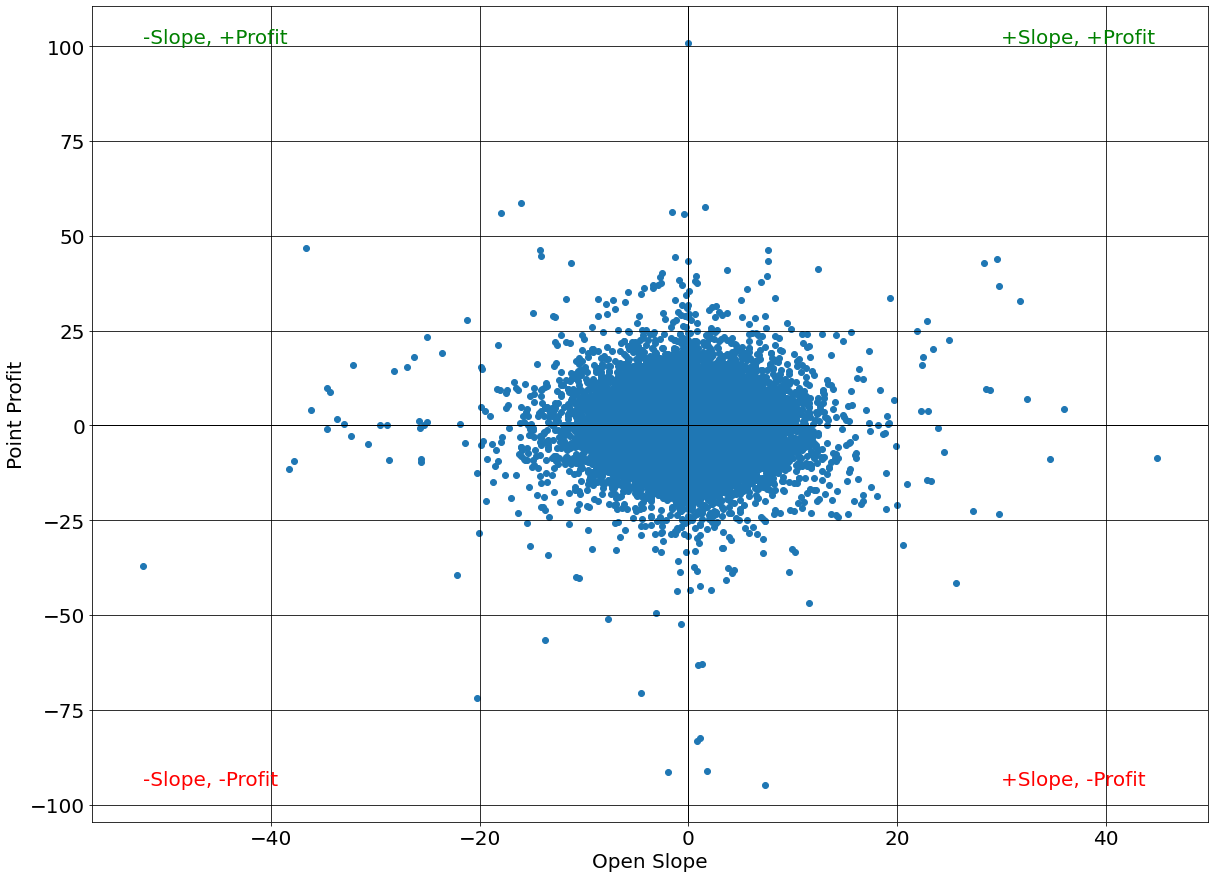

In [75]:
x1 = ES['open_slope'].max()/1.5
x2 = ES['open_slope'].min()
y1 = ES['sma_point_profit'].max()
y2 = ES['sma_point_profit'].min()

plt.figure(figsize=(20, 15))
plt.rc('font', size=20)
plt.grid(True)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.scatter(ES['open_slope'],ES['sma_point_profit'])
plt.xlabel('Open Slope')
plt.ylabel('Point Profit')
plt.text(x1, y1, '+Slope, +Profit', color='green')
plt.text(x1, y2, '+Slope, -Profit', color='red')
plt.text(x2, y2, '-Slope, -Profit', color='red')
plt.text(x2, y1, '-Slope, +Profit', color='green')
plt.show()

# Past Iterations of Code

In [76]:
# ES = pd.read_csv('HistoricalData_ES.csv') #reads in ES data to ES
# ES['Close'] = ES['Close/Last'] #copies said column
# ES.drop(columns = ['Close/Last'], inplace = True) #drops 'columns' from dataframe, inplace makes it permanent
# ES = ES[['Date', 'Open', 'Close', 'High', 'Low', 'Volume']] #orders columns
# ES.dropna(inplace=True) #drops records that we can't really use 
# ES #prints top and bottom five records of dataframe

In [77]:
# true_sig = 'sma_s' # can be prix_met or 'sma_s'

# ES['signal'] = np.where(ES[true_sig] > ES['sma_c'], 1, 0) #long signal
# ES['signal'] = np.where(ES[true_sig] < ES['sma_c'], -1, ES['signal']) #short signal
# # ES.dropna(inplace=True) #drops records that we can't really use due to nature of sma_s's
# # ES

In [78]:
# # Generates the signal for wma
# true_sig = 'wma_s' # can be prix_met or 'wma_s'

# ES['signal2'] = np.where(ES[true_sig] > ES['wma_c'], 1, 0) 
# ES['signal2'] = np.where(ES[true_sig] < ES['wma_c'], -1, ES['signal2'])
# # ES.dropna(inplace=True) #drops records that we can't really use due to nature of sma_s's
# # ES

In [79]:
# # Generates the signal for ema
# true_sig = 'ema_s' # can be prix_met or 'ema_s'

# ES['signal3'] = np.where(ES[true_sig] > ES['ema_c'], 1, 0) 
# ES['signal3'] = np.where(ES[true_sig] < ES['ema_c'], -1, ES['signal3'])
# ES.dropna(inplace=True) #drops records that we can't really use due to nature of sma_s's
# ES

In [80]:
# arrows = 'Open'

# plt.rcParams.update({'font.size': 50})
# plt.rcParams['figure.figsize'] = 100,40
# plt.grid(True, alpha = .3)
# plt.plot(ES_viz.iloc[0:]['Open'], label = 'ES_viz')
# plt.plot(ES_viz.iloc[0:]['sma_c'], label = 'sma_c')
# plt.plot(ES_viz[0:].loc[ES_viz.sma_entry == 2].index, ES_viz[0:][arrows][ES_viz.sma_entry == 2], '^',
#         color = 'g', markersize = 12)
# plt.plot(ES_viz[0:].loc[ES_viz.sma_entry == -2].index, ES_viz[0:][arrows][ES_viz.sma_entry == -2], 'v',
#         color = 'r', markersize = 12)
# plt.plot(np.cumsum(ES_viz['sma_point_profit'])+ES_viz.Open[0], label = 'SMA System')
# plt.plot(np.cumsum(ES_viz['wma_point_profit'])+ES_viz.Open[0], label = 'wma System')
# plt.plot(np.cumsum(ES_viz['ema_point_profit'])+ES_viz.Open[0], label = 'ema System')
# plt.grid
# plt.legend(loc=2)

In [81]:
# arrows = 'Open'

# plt.rcParams.update({'font.size': 50})
# plt.rcParams['figure.figsize'] = 100,40
# plt.grid(True, alpha = .3)
# plt.plot(ES_viz.iloc[0:]['Open'], label = 'ES_viz')
# plt.plot(ES_viz.iloc[0:]['wma_c'], label = 'wma_c')
# plt.plot(ES_viz[0:].loc[ES_viz.wma_entry == 2].index, ES_viz[0:][arrows][ES_viz.wma_entry == 2], '^',
#         color = 'g', markersize = 12)
# plt.plot(ES_viz[0:].loc[ES_viz.wma_entry == -2].index, ES_viz[0:][arrows][ES_viz.wma_entry == -2], 'v',
#         color = 'r', markersize = 12)
# plt.plot(np.cumsum(ES_viz['sma_point_profit'])+ES_viz.Open[0], label = 'SMA System')
# plt.plot(np.cumsum(ES_viz['wma_point_profit'])+ES_viz.Open[0], label = 'wma System')
# plt.plot(np.cumsum(ES_viz['ema_point_profit'])+ES_viz.Open[0], label = 'ema System')
# plt.grid
# plt.legend(loc=2)

In [82]:
#running this code more than once in the kernal screws up the affected columns; 
#need to move the signal down one row with shift() if we use Open to Open differences
#could also possibly shift point_profit
#could possibly do this by taking ['signal'] and ['movement'] out, slicing one row off appropriate ends and then
#creating ['sma_point_profit']
# ES['signal'] = ES['signal'].shift()

In [83]:
# arrows = 'Open'

# plt.rcParams.update({'font.size': 50})
# plt.rcParams['figure.figsize'] = 100,40
# plt.grid(True, alpha = .3)
# plt.plot(ES_viz.iloc[0:]['Open'], label = 'ES_viz')
# plt.plot(ES_viz.iloc[0:]['ema_c'], label = 'ema_c')
# plt.plot(ES_viz[0:].loc[ES_viz.ema_entry == 2].index, ES_viz[0:][arrows][ES_viz.ema_entry == 2], '^',
#         color = 'g', markersize = 12)
# plt.plot(ES_viz[0:].loc[ES_viz.ema_entry == -2].index, ES_viz[0:][arrows][ES_viz.ema_entry == -2], 'v',
#         color = 'r', markersize = 12)
# plt.plot(np.cumsum(ES_viz['sma_point_profit'])+ES_viz.Open[0], label = 'SMA System')
# plt.plot(np.cumsum(ES_viz['wma_point_profit'])+ES_viz.Open[0], label = 'wma System')
# plt.plot(np.cumsum(ES_viz['ema_point_profit'])+ES_viz.Open[0], label = 'ema System')
# plt.grid
# plt.legend(loc=2)

### The following return code uses the methods from the original example for profit calculation.

In [84]:
# Something is wrong with these two cells, or you just don't understand what's happening. Investigate and fix please

# buy_hold = np.exp(ES['return']).cumprod()[-1] -1
# buy_hold_percent = "{:.0%}".format(buy_hold)
# print(buy_hold_percent)

In [85]:
# system_return = np.exp(ES['system_return']).cumprod()[-1] -1
# system_percent = "{:.0%}".format(system_return)
# print(system_percent)

In [86]:
# import numpy as np
# import pandas as pd
# import pandas_datareader as pdr
# import matplotlib.pyplot as plt

In [87]:
# spy = pdr.get_data_yahoo('SPY') #uses pdr to get yahoo data on spy
# day = np.arange(1, len(spy) + 1) #creates day column
# spy['day'] = day #adds day column to dataframe
# spy.drop(columns = ['Adj Close', 'Volume'], inplace = True) #drops 'columns' from dataframe, inplace makes it permanent
# spy = spy[['day', 'Open', 'High', 'Low', 'Close']]
# print(spy) #prints top and bottom five records of dataframe

In [88]:
# spy.info() #prints information on data contained in the dataframe

In [89]:
# spy['1-day'] = spy['Open'].rolling(1).mean().shift() #this calculates our 1sma_s and stores it in the dataframe
# spy['11-day'] = spy['Open'].rolling(5).mean().shift() #this calculates our 11sma_s and stores it in the dataframe
# spy[7:25] #printing this range shows how the dataframe omits records for our sma_s's because of how many rows are needed to 
# #calculate them
# spy

In [90]:
# spy['signal'] = np.where(spy['Open'] > spy['11-day'], 1, 0) #long signal
# spy['signal'] = np.where(spy['Open'] < spy['11-day'], -1, spy['signal']) #short signal
# spy.dropna(inplace=True) #drops records that we can't really use due to nature of sma_s's
# print(spy)

In [91]:
# spy['Return'] = np.log(spy['Open']).diff() #somehow this represents the buy and hold return
# spy['system_return'] = spy['signal'] * spy['Return'] #this represents the trading system return
# spy['entry'] = spy.signal.diff() #shows where we changed trade direction
# print(spy)

In [92]:
# plt.rcParams['figure.figsize'] = 60,30
# plt.grid(True, alpha = .3)
# plt.plot(spy.iloc[0:]['Open'], label = 'spy')
# #plt.plot(spy.iloc[0:]['1-day'], label = '1-day')
# plt.plot(spy.iloc[0:]['11-day'], label = '11-day')
# plt.plot(spy[0:].loc[spy.entry == 2].index, spy[0:]['Open'][spy.entry == 2], '^',
#         color = 'g', markersize = 12)
# plt.plot(spy[0:].loc[spy.entry == -2].index, spy[0:]['Open'][spy.entry == -2], 'v',
#         color = 'r', markersize = 12)
# plt.legend(loc=2)

In [93]:
# spy['system_return'] = spy.signal * spy.Return
# plt.rcParams['figure.figsize'] = 30,15
# plt.plot(np.exp(spy.Return).cumprod(), label = 'Buy/Hold')
# plt.plot(np.exp(spy.system_return).cumprod(), label = 'System')
# plt.legend(loc=2)
# plt.grid(True, alpha = .3)

In [94]:
# plt.rcParams['figure.figsize'] = 50,25
# plt.plot(np.exp(spy['Return']).cumprod(), label = 'Buy/Hold')
# plt.plot(np.exp(spy['system_return']).cumprod(), label = 'System')
# plt.legend(loc = 2)
# plt.grid(True, alpha = .3)

In [95]:
# np.exp(spy['Return']).cumprod()[-1] -1

In [96]:
# plt.rcParams['figure.figsize'] = 100,25
# plt.plot(np.exp(ES['return']).cumprod(), label = 'Buy/Hold')
# plt.plot(np.exp(ES['system_return']).cumprod(), label = 'System')
# plt.legend(loc = 2)
# plt.grid(True, alpha = .3)

In [97]:
# np.exp(spy['system_return']).cumprod()[-1] -1

In [98]:
# # This code chunk is here to divide and experiment with the EMA function to better understand it
# # Calculate the weighting multiplier
# alpha = 2 / (period + 1)

# # Calculate the initial EMA value using a simple moving average
# ema_init = ES['sma_c'][period-1]

# # Calculate the EMA values for the remaining data
# ema_values = []
# for i in range(period, len(data)):
#     ema = alpha * data[column_name][i] + (1 - alpha) * ema_init
#     ema_init = ema
#     ema_values.append(ema)

# ema_values = [float('nan')] * (period) + ema_values
# ES['ema_c'] = ema_values